# Evaluation of multi-omics GRN inference methods
## Preprocessing perturbation and multiomics data
### by Jalil Nourisa

# <a id='toc2_'></a>[Imports](#toc0_)

In [13]:
import scipy

import os, binascii
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import scanpy.external as sce
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox
import anndata as ad
# import pertpy 

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

import rpy2.robjects as ro
import matplotlib
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex='false')
matplotlib.rcParams.update({'font.size': 10})
colors_cell_type = ['#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray']


sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

ro.pandas2ri.activate()

%load_ext rpy2.ipython

main_dir = '../'
work_dir = f'{main_dir}/output'

out_edger_dir= f'{work_dir}/de_analysis/edger'
out_limma_dir= f'{work_dir}/de_analysis/limma'


kaggle_dir = '../input/kaggle/input/open-problems-single-cell-perturbations'
bulk_index = ['sm_name', 'cell_type', 'plate_name', 'row']
CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']
train_cell_types =  ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']
controls2 = ['Dabrafenib', 'Belinostat']

T_cell_types = ['T regulatory cells', 'T cells CD8+', 'T cells CD4+']
cell_types_major = ['T cells', 'NK cells', 'B cells', 'Myeloid cells']
cell_type_map = {cell_type: 'T cells' if cell_type in T_cell_types else cell_type for cell_type in CELL_TYPES}


outliers_me = np.asarray(['AT13387', 'Alvocidib', 'BMS-387032', 'CEP-18770 (Delanzomib)',
       'CGM-097', 'CGP 60474', 'Ganetespib (STA-9090)', 'I-BET151',
       'IN1451', 'LY2090314', 'MLN 2238', 'Oprozomib (ONX 0912)',
       'Proscillaridin A;Proscillaridin-A', 'Resminostat',
       'UNII-BXU45ZH6LI', 'Vorinostat'])
train_sm_names = np.asarray(['Idelalisib', 'Crizotinib', 'Linagliptin', 'Palbociclib',
       'Alvocidib', 'LDN 193189', 'R428',
       'Porcn Inhibitor III', 'Foretinib', 'MLN 2238',
       'Penfluridol', 'Dactolisib', 'O-Demethylated Adapalene',
       'Oprozomib (ONX 0912)', 'CHIR-99021'])

negative_control = 'Dimethyl Sulfoxide'

from matplotlib.patches import Patch
# the stacked bar code is adopted from Ambrosm
def plot_stacked_bar_chart(cell_types_in_drops, title='', xticklabels=None, colors=None, figsize=(25, 4)):
    # Add a column of zeros to the left and compute the cumulative sums
    cc = np.hstack([np.zeros((len(cell_types_in_drops), 1)), cell_types_in_drops])
    cc_cs = cc.cumsum(axis=1)

    fig, ax = plt.subplots(figsize=figsize)
    cell_types = cell_types_in_drops.columns
    for i in range(len(cell_types)):
        ax.bar(np.arange(len(cc_cs)),
               cc_cs[:,i+1] - cc_cs[:,i],
               bottom=cc_cs[:,i],
               label=cell_types[i], color=colors_cell_type[i])
    ax.set_title(title)
    # first_legend = ax.legend(title='Cell Types')
    ax.set_xticks(np.arange(len(cc_cs)))
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels, rotation=90)
    if colors is not None:
        for ticklabel, color in zip(ax.get_xticklabels(), colors):
            ticklabel.set_color(color)
    ax.legend()
    color_legend_handles = [
        Patch(facecolor='red', label='-'),
        Patch(facecolor='blue', label='-'),
        Patch(facecolor='green', label='-'),
    ]

    
    return fig, ax

def generate_colors(num_colors):
    np.random.seed(30)  # For reproducibility
    colors = np.random.rand(num_colors, 3)  # Generate colors in RGB format
    return colors

# Generate 150 distinct colors
colors_list = generate_colors(150)

def plot_scatter(adata_df, obs_index, xs, ys, x_label='', y_label='', log=True, log_y=False, figsize=(5, 7)):
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=False)
    alpha = .2
    edgecolors = 'white'
    for i_index, index in enumerate(obs_index):
        i = i_index // 2
        j = i_index % 2
        ax = axes[j]

        index_vars = adata_df.index.get_level_values(index)
        if index=='sm_name':
            # included_vars = train_sm_names
            # included_vars = index_vars.unique()
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[mask], ys[mask], label='Positive control', alpha=alpha, color='cyan', edgecolors=edgecolors)
            mask = (index_vars==negative_control)
            ax.scatter(xs[mask], ys[mask], label='Negative control', alpha=alpha, color='green', edgecolors=edgecolors)
            mask = (index_vars.isin(controls2))
            ax.scatter(xs[~mask], ys[~mask], label='Rest', alpha=alpha, color='blue', edgecolors=edgecolors)
            
        else:
            included_vars = index_vars.unique()
            colors = ['blue', 'red', 'green', 'orange', 'purple', 'gray']

            for i, var in enumerate(included_vars):
                # color=colors_list[i]
                label = var
                mask = (index_vars == var)
                ax.scatter(xs[mask], ys[mask], label=var, alpha=alpha, edgecolors=edgecolors, color=colors[i])
            
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if log:
            ax.set_xscale('log')
        if log_y:
            ax.set_yscale('log')
        ax.margins(0.05)
        ax.spines[['right', 'top']].set_visible(False)
        # ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
        prop = {'size': 9}
        ax.legend(prop=prop, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)
    #plt.axvline(x=25, linestyle='--', linewidth=1, color='black')
    plt.tight_layout()
    return fig, axes


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Perturbation data: single-cell count


In [3]:
sc_counts = ad.read(f'{main_dir}/input/sc_counts.h5ad')

In [8]:
sample_sum = (sc_counts.X!=0).sum(axis=0)

# <a id='toc3_'></a>[Format adata](#toc0_)

In [68]:
adata_train_df = pd.read_parquet(os.path.join(kaggle_dir, 'adata_train.parquet'))
adata_obs_meta_df = pd.read_csv(os.path.join(kaggle_dir, 'adata_obs_meta.csv'))
de_train = pd.read_parquet(os.path.join(kaggle_dir, 'de_train.parquet'))
adata_excluded_ids_df = pd.read_csv(os.path.join(kaggle_dir, 'adata_excluded_ids.csv'))

KeyboardInterrupt: 

In [ ]:
reindexed_adata_train_df = adata_train_df.reset_index().set_index(['obs_id', 'gene'])
adata_excluded_ids_index = adata_excluded_ids_df.set_index(['obs_id', 'gene']).sort_index().index

selection = ~reindexed_adata_train_df.index.isin(adata_excluded_ids_index)
adata_train_df = reindexed_adata_train_df[selection]

adata_train_df = adata_train_df.reset_index().set_index('index')

In [ ]:
adata_train_df['obs_id'] = adata_train_df['obs_id'].astype('category')
adata_train_df['gene'] = adata_train_df['gene'].astype('category')

obs_ids = adata_train_df['obs_id'].unique()
obs_id_map = dict(zip(obs_ids, range(len(obs_ids))))

genes = adata_train_df['gene'].unique()
gene_map = dict(zip(genes, range(len(genes))))

adata_train_df['obs_index'] = adata_train_df['obs_id'].map(obs_id_map)
adata_train_df['gene_index'] = adata_train_df['gene'].map(gene_map)

normalized_counts_values = adata_train_df['normalized_count'].to_numpy()
counts_values = adata_train_df['count'].to_numpy()

row_indices = adata_train_df['obs_index'].to_numpy()
col_indices = adata_train_df['gene_index'].to_numpy()

counts = scipy.sparse.csr_matrix((counts_values, (row_indices, col_indices)))

obs_df = pd.Series(obs_ids, name='obs_id').to_frame()
var_df = pd.Series(genes, name='gene').to_frame()

obs_df = obs_df.set_index('obs_id')
var_df = var_df.set_index('gene')

obs_df.index = obs_df.index.astype('str')
var_df.index = var_df.index.astype('str')

kaggle_adata = ad.AnnData(
    X=counts,
    obs=obs_df,
    var=var_df,
    dtype=np.uint32,
)

index_ordering_before_join = kaggle_adata.obs.index
kaggle_adata.obs = kaggle_adata.obs.join(adata_obs_meta_df.set_index('obs_id'))
index_ordering_after_join = kaggle_adata.obs.index
assert (index_ordering_before_join == index_ordering_after_join).all()

kaggle_adata.write_h5ad(f'{work_dir}/preprocess/kaggle_adata.h5ad')

# Pseudobulking counts 

In [150]:
import anndata
import pandas as pd
import numpy as np
import sklearn
import scipy
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, message="The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated")
warnings.filterwarnings('ignore', category=UserWarning, message="No data for colormapping provided via 'c'")

import anndata as ad
import scanpy as sc

import matplotlib.pyplot as plt

import os, binascii
kaggle_adata = anndata.read_h5ad(f'{work_dir}/preprocess/kaggle_adata.h5ad')

In [151]:
kaggle_adata

AnnData object with n_obs × n_vars = 240090 × 18211
    obs: 'library_id', 'plate_name', 'well', 'row', 'col', 'cell_id', 'donor_id', 'cell_type', 'sm_lincs_id', 'sm_name', 'SMILES', 'dose_uM', 'timepoint_hr', 'control'

In [152]:
from scipy import sparse

def sum_by(adata: ad.AnnData, col: str) -> ad.AnnData:
    """
    Adapted from this forum post: 
    https://discourse.scverse.org/t/group-sum-rows-based-on-jobs-feature/371/4
    """
    
    assert pd.api.types.is_categorical_dtype(adata.obs[col])

    # sum `.X` entries for each unique value in `col`
    cat = adata.obs[col].values

    indicator = sparse.coo_matrix(
        (
            np.broadcast_to(True, adata.n_obs),
            (cat.codes, np.arange(adata.n_obs))
        ),
        shape=(len(cat.categories), adata.n_obs),
    )
  
    sum_adata = ad.AnnData(
        indicator @ adata.X,
        var=adata.var,
        obs=pd.DataFrame(index=cat.categories),
    )
    
    # copy over `.obs` values that have a one-to-one-mapping with `.obs[col]`
    obs_cols = adata.obs.columns
    obs_cols = list(set(adata.obs.columns) - set([col]))
    
    one_to_one_mapped_obs_cols = []
    nunique_in_col = adata.obs[col].nunique()
    for other_col in obs_cols:
        if len(adata.obs[[col, other_col]].drop_duplicates()) == nunique_in_col:
            one_to_one_mapped_obs_cols.append(other_col)

    joining_df = adata.obs[[col] + one_to_one_mapped_obs_cols].drop_duplicates().set_index(col)
    assert (sum_adata.obs.index == sum_adata.obs.join(joining_df).index).all()
    sum_adata.obs = sum_adata.obs.join(joining_df)
    sum_adata.obs.index.name = col
    sum_adata.obs = sum_adata.obs.reset_index()
    sum_adata.obs.index = sum_adata.obs.index.astype('str')

    return sum_adata

In [153]:
# aggregate single cell measurements for each well (of each plate)
kaggle_adata.obs['plate_well_cell_type'] = kaggle_adata.obs['plate_name'].astype('str') \
    + '_' + kaggle_adata.obs['well'].astype('str') \
    + '_' + kaggle_adata.obs['cell_type'].astype('str')
kaggle_adata.obs['plate_well_cell_type'] = kaggle_adata.obs['plate_well_cell_type'].astype('category')
# actuall bulking
bulk_adata = sum_by(kaggle_adata, 'plate_well_cell_type')
bulk_adata.obs['cell_count'] = kaggle_adata.obs.groupby('plate_well_cell_type').size().values
bulk_adata.obs = bulk_adata.obs.drop(columns=['plate_well_cell_type'])
bulk_adata.X = np.array(bulk_adata.X.todense())
plate_name_update = {
    'plate_0': 'plate_2',
     'plate_1': 'plate_3',
     'plate_2': 'plate_1',
     'plate_3': 'plate_4',
     'plate_4': 'plate_0',
     'plate_5': 'plate_5',
}

bulk_adata.obs['plate_name'] = bulk_adata \
    .obs['plate_name'] \
    .map(plate_name_update) \
    .astype('str')

print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)
bulk_adata.var = bulk_adata.var.reset_index()

ratio of missingness 0.4181703709564913


In [154]:
bulk_adata.obs['positive_control'] = bulk_adata.obs.sm_name.isin(controls2).astype('category')
bulk_adata.obs['negative_control'] = (bulk_adata.obs.sm_name == negative_control).astype('category')

In [155]:
bulk_adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata.h5ad')

bulk_adata_df = pd.DataFrame(bulk_adata.X, columns=bulk_adata.var.index, index=bulk_adata.obs.index)
bulk_adata_df = pd.concat([bulk_adata.obs[bulk_index],  bulk_adata_df], axis=1).set_index(bulk_index)
bulk_adata_df.to_csv(f'{work_dir}/preprocess/bulk_adata_df.csv')


In [ ]:
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import numpy as np
from scipy.stats import median_abs_deviation

sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)
plt.rcParams['figure.figsize'] = (4,4)


controls2 = ['Dabrafenib', 'Belinostat']

tag ='complete_tcells' #'complete'

sc_counts = ad.read(f'input/sc_counts.h5ad')
sc_counts.var_names_make_unique()

# EDA on pseudobulked data

In [18]:
de_tag = 'complete_original'
adata_tag = 'complete_tcells'# 'complete_tcells'

In [19]:

bulk_adata = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_{adata_tag}.h5ad')

sample_n = bulk_adata.shape[0]
gene_n = bulk_adata.shape[1]
bulk_adata.var = bulk_adata.var.rename(columns={'index':'gene'})
obs_index= ['cell_type', 'sm_name']
# some preprocess
bulk_adata.X = np.nan_to_num(bulk_adata.X, nan=0)
bulk_adata

AnnData object with n_obs × n_vars = 2277 × 15926
    obs: 'plate_well_cell_type', 'plate_name', 'positive_ctr', 'cell_type', 'timepoint_hr', 'dose_uM', 'row', 'container_format', 'hashtag_id', 'well', 'split', 'donor_id', 'raw_cell_id', 'col', 'sm_name', 'cell_id', 'cell_count'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'

In [20]:
bulk_adata.obs.cell_type.unique()

['B cells', 'Myeloid cells', 'NK cells', 'T cells']
Categories (4, object): ['B cells', 'Myeloid cells', 'NK cells', 'T cells']

In [21]:
print('ratio of missingness' , (bulk_adata.X==0).sum()/bulk_adata.X.size)

ratio of missingness 0.22444928236660652


In [22]:
bulk_adata_df = pd.DataFrame(bulk_adata.X, index= pd.MultiIndex.from_frame(bulk_adata.obs[bulk_index]), columns=bulk_adata.var.index)
sum_count = bulk_adata_df.sum(axis=1)
cell_count = bulk_adata.obs.groupby(bulk_index).apply(lambda df:df['cell_count'].sum()).reindex_like(bulk_adata_df)
# non_missing_count = (bulk_adata_df!=0).sum(axis=1)
# missing_count = (bulk_adata_df==0).sum(axis=1)
bulk_adata_df.head()

index                                                    A1BG   A1BG-AS1  \
sm_name               cell_type     plate_name row                         
TIE2 Kinase Inhibitor B cells       010        A     5.667065  25.116704   
                      Myeloid cells 010        A     4.048687  37.259095   
                      NK cells      010        A     5.636244  15.596035   
                      T cells       010        A    26.450145  60.032780   
MK-5108               B cells       010        A    15.882003  46.297878   

index                                                      A2M    A2M-AS1  \
sm_name               cell_type     plate_name row                          
TIE2 Kinase Inhibitor B cells       010        A      0.000000   0.000000   
                      Myeloid cells 010        A    178.181432   8.219843   
                      NK cells      010        A     16.870519  79.953526   
                      T cells       010        A     20.027573  41.378313   
MK-5108               B cells       010        A      0.000000   0.000000   

index                                                  A2MP1       AAAS  \
sm_name               cell_type     plate_name row                        
TIE2 Kinase Inhibitor B cells       010        A    0.000000  47.514853   
                      Myeloid cells 010        A    0.000000  65.961761   
                      NK cells      010        A    5.201106  31.139983   
                      T cells       010        A    5.212115  46.238904   
MK-5108               B cells       010        A    0.000000  26.924863   

index                                                    AACS       AAGAB  \
sm_name               cell_type     plate_name row                          
TIE2 Kinase Inhibitor B cells       010        A    22.136307   39.019949   
                      Myeloid cells 010        A    28.848453  143.619865   
                      NK cells      010        A     4.543634   27.014839   
                      T cells       010        A    20.335129  145.775856   
MK-5108               B cells       010        A    16.242488   58.752234   

index                                                     AAK1       AAMDC  \
sm_name               cell_type     plate_name row                           
TIE2 Kinase Inhibitor B cells       010        A      5.571579   47.909365   
                      Myeloid cells 010        A    266.824184  126.687780   
                      NK cells      010        A    214.287430   34.089226   
                      T cells       010        A    931.922436  105.484501   
MK-5108               B cells       010        A     16.507022    4.768600   

index                                               ...       ZUP1       ZW10  \
sm_name               cell_type     plate_name row  ...                         
TIE2 Kinase Inhibitor B cells       010        A    ...  62.706203  26.508839   
                      Myeloid cells 010        A    ...  84.890857  56.254286   
                      NK cells      010        A    ...  28.291056   9.574722   
                      T cells       010        A    ...  93.369034  31.457016   
MK-5108               B cells       010        A    ...  43.852252   5.449502   

index                                                  ZWILCH      ZWINT  \
sm_name               cell_type     plate_name row                         
TIE2 Kinase Inhibitor B cells       010        A    24.729589   0.000000   
                      Myeloid cells 010        A    85.253123  30.738344   
                      NK cells      010        A    16.613308   0.000000   
                      T cells       010        A    25.925718  15.755766   
MK-5108               B cells       010        A     0.000000   0.000000   

index                                                    ZXDA       ZXDB  \
sm_name               cell_type     plate_name row                         
TIE2 Kinase Inhibitor B cells       010        A    10.456803

### Sum of counts vs std

(<Figure size 500x700 with 2 Axes>,
 array([<Axes: xlabel='Sum of counts', ylabel='Std'>,
        <Axes: xlabel='Sum of counts', ylabel='Std'>], dtype=object))

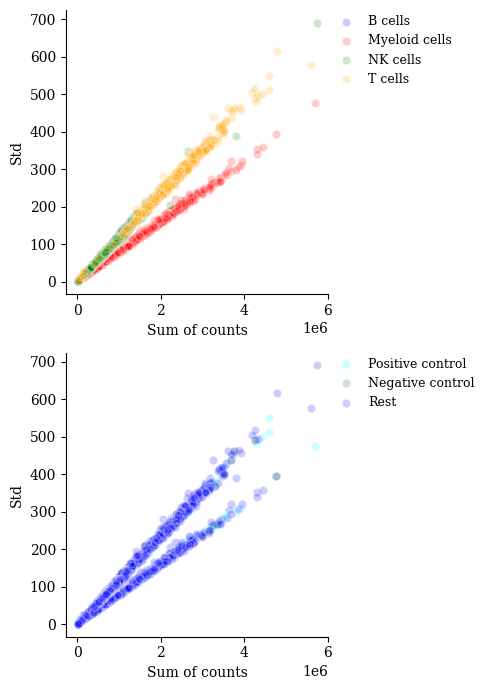

In [23]:
xs = sum_count
ys = np.std(np.abs(bulk_adata_df), axis=1)
plot_scatter(bulk_adata_df, obs_index, xs, ys, x_label='Sum of counts', y_label='Std', log=False, log_y=False)



### Sum of counts vs cell count

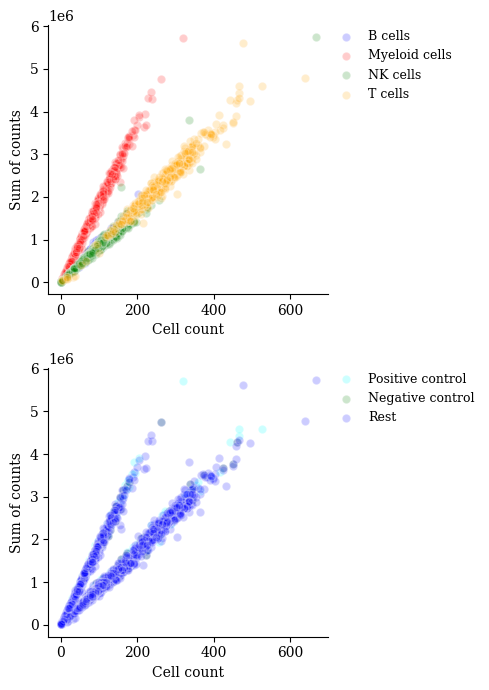

In [24]:
xs = cell_count
ys = sum_count
fig, axes = plot_scatter(bulk_adata_df, obs_index, xs, ys, x_label='Cell count', y_label='Sum of counts', log=False, log_y=False)

# fig.savefig(f'{work_dir}/preprocess/figs/eda1_cellcount_sumcounts_raw.png', dpi=150, transparent=True)

## Number of psuedobulked samples 

In [25]:
sample_n = bulk_adata.obs.groupby(['cell_type', 'sm_name']).size().unstack('cell_type')
sample_n.fillna(0, inplace=True) # fill nans and sort for train cell type

sample_n['total'] = sample_n.sum(axis=1) # Sort by the four training cell types
sample_n.sort_values('total', inplace=True)
sample_n.tail()

cell_type,B cells,Myeloid cells,NK cells,T cells,total
sm_name,,,,,
FK 866,3,3,3,3,12
Flutamide,3,3,3,3,12
Dimethyl Sulfoxide,48,48,48,48,192
Belinostat,48,48,48,48,192
Dabrafenib,48,48,48,48,192


In [26]:
# Plot for non controls
cc = sample_n.loc[~sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index
cell_types = bulk_adata.obs['cell_type'].unique()

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    if sm_name in outliers_me:
        colors.append('red')
    else:
        colors.append('black')

fig, ax = plot_stacked_bar_chart(cc[cell_types], 'Non controls: Sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(25, 4))
plt.legend()

144


TypeError: plot_stacked_bar_chart() got an unexpected keyword argument 'xticks'

3


(<Figure size 500x250 with 1 Axes>,
 <Axes: title={'center': 'Controls: sample counts for compound-cell type summed over pseudobulked samples'}>)

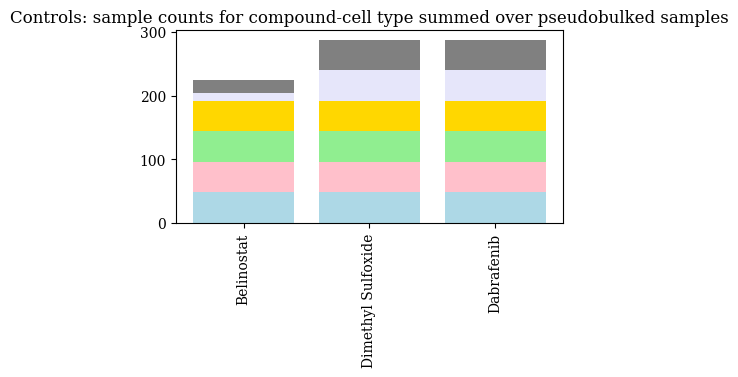

In [ ]:
# Plot for non controls
cc = sample_n.loc[sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    colors.append('black')

plot_stacked_bar_chart(cc[cell_types], 'Controls: sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(5, 2.5))

## Distribution of cell counts

In [ ]:
cell_count = bulk_adata.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].sum())


cell_count_m = cell_count.unstack('cell_type') # shape (n_compounds, n_cell_types) matrix

cell_count_m = cell_count_m.fillna(0) # fill nans and sort for train cell type

cell_count_m['total'] = cell_count_m.sum(axis=1) # Sort by the number of cells of the four training cell types
cell_count_m.sort_values('total', inplace=True)

cell_count_m.head()

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells,total
sm_name,,,,,,,
Alvocidib,3.0,1.0,6.0,8.0,0.0,33.0,51.0
CGP 60474,3.0,0.0,6.0,15.0,0.0,68.0,92.0
BMS-387032,6.0,0.0,195.0,143.0,10.0,68.0,422.0
UNII-BXU45ZH6LI,96.0,28.0,28.0,257.0,6.0,16.0,431.0
ABT737,18.0,238.0,165.0,414.0,41.0,35.0,911.0


In [ ]:
cell_count = cell_count.to_frame()
cell_count['sample'] =['__'.join(item) for item in cell_count.index]
cell_count = cell_count.reset_index().set_index(['sm_name', 'cell_type', 'sample'])
cell_count.head()

0
sm_name                                            cell_type     sample                                                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells       5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6...  225
                                                   Myeloid cells 5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6...   29
                                                   NK cells      5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6...  363
                                                   T cells CD4+  5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6...  845
                                                   T cells CD8+  5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6...   64

### Ratio of cell counts for different cell types

In [ ]:
sum_counts_celltypes = cell_count.reset_index().drop(columns='sm_name').groupby('cell_type').sum().reset_index()

sum_counts_celltypes

,cell_type,0
0,B cells,46356
1,Myeloid cells,47485
2,NK cells,59170
3,T cells CD4+,124971
4,T cells CD8+,15563
5,T regulatory cells,8240


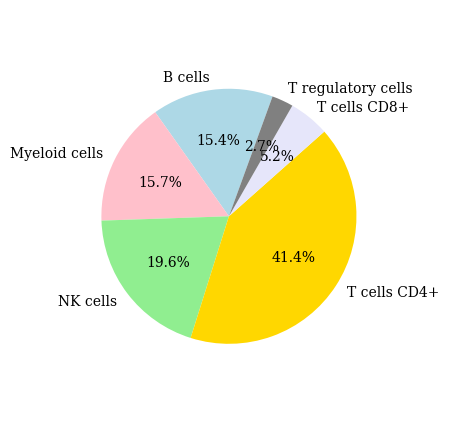

In [ ]:
fig, ax = plt.subplots(1,1 , figsize=(4.5, 4.5))  # Adjust the figure size as needed

sum_counts_celltypes_dict = sum_counts_celltypes.set_index('cell_type').to_dict()[0]
ax.pie(sum_counts_celltypes_dict.values(), labels=sum_counts_celltypes_dict.keys(), autopct='%1.1f%%', startangle=70, colors=colors_cell_type)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios.png', dpi=100, transparent=True)
plt.show()

## Compound based cell count distribution 

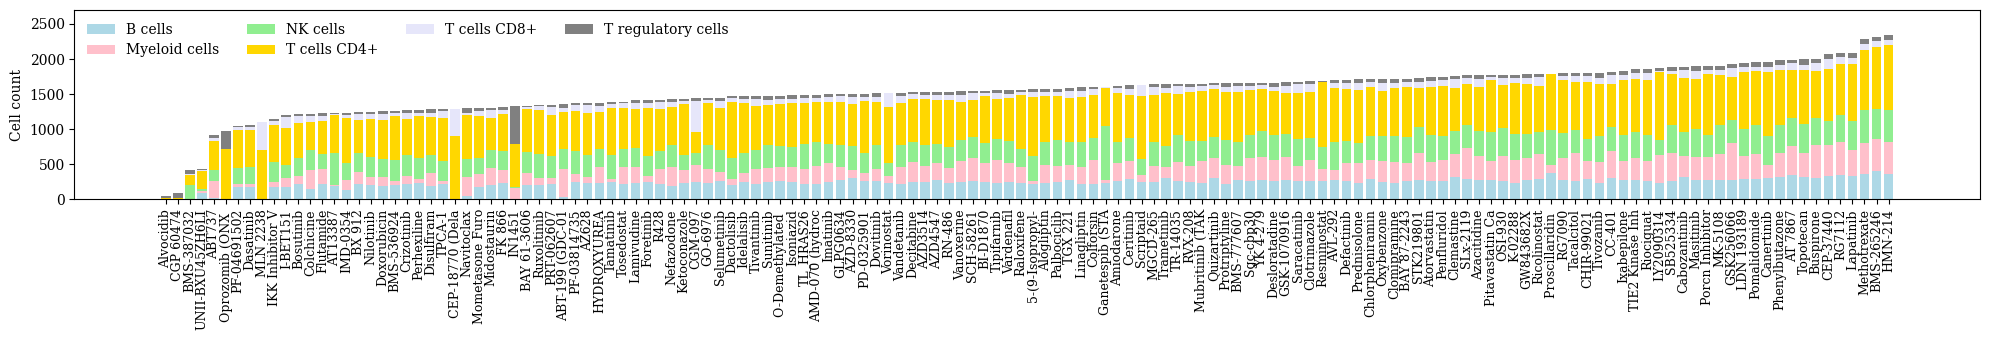

In [ ]:
# Plot for non controls
cc = cell_count_m.loc[~cell_count_m.index.get_level_values('sm_name').isin(controls3),:]

sorted_compound_names = cc.index
xticks = np.arange(len(cc))
xticklabels = sorted_compound_names
xticklabels_short = [label[0:20] for label in xticklabels]


colors = []

for i, sm_name in enumerate(xticklabels):
    colors.append('black')

xticklabels_short = [label[0:15] for label in xticklabels]

fig, ax = plot_stacked_bar_chart(cc[cell_types], '', xticks=xticks, xticklabels=xticklabels_short, colors=colors, figsize=(20,3.5))
ax.set_ylabel('Cell count')
# ax.add_artist(first_legend)
x_min, x_max = ax.get_ylim()
x_margin = 0.1 * (x_max - x_min)
ax.set_ylim(x_min, x_max + x_margin)

x_min, x_max = ax.get_xlim()
x_margin = 0 * (x_max - x_min)
ax.set_xlim(x_min, x_max - x_margin)
# ax.legend(title='Cell types', loc='left', bbox_to_anchor=(1, 0.5))
ax.legend(ncol=4, frameon=False, loc='upper left')
plt.xticks(fontsize=9)
plt.tight_layout()
# fig.savefig(f'{work_dir}/preprocess/figs/ambros_style_graph.png', dpi=100)

## Distribution of cell count for controls' samples

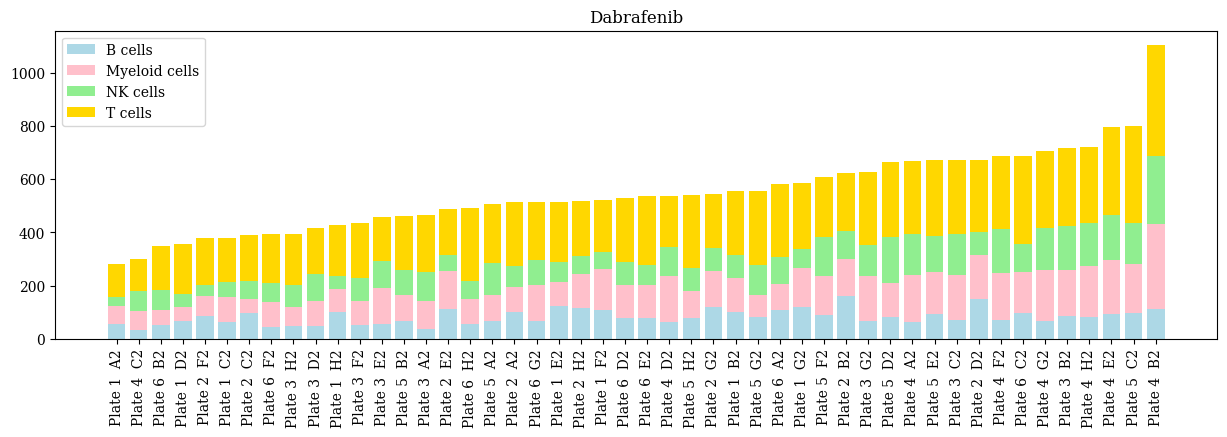

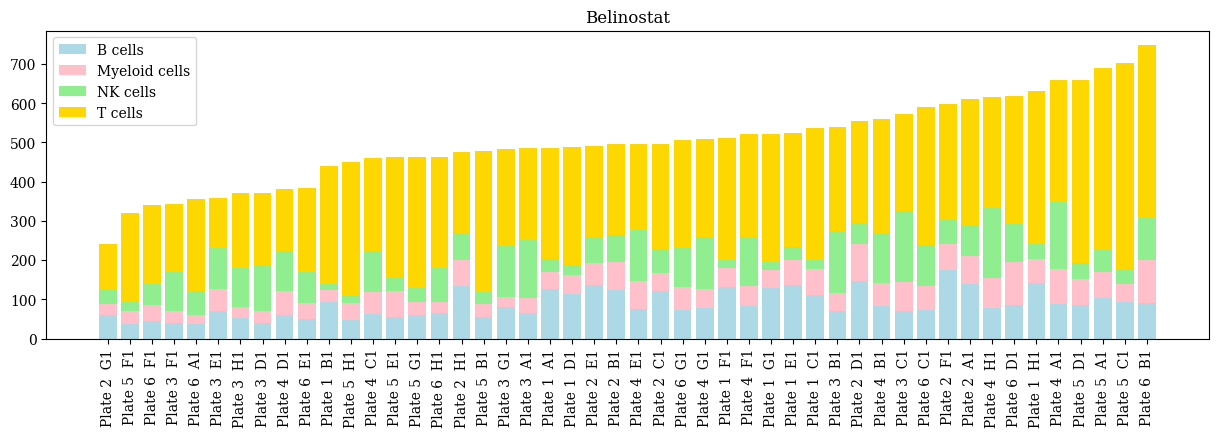

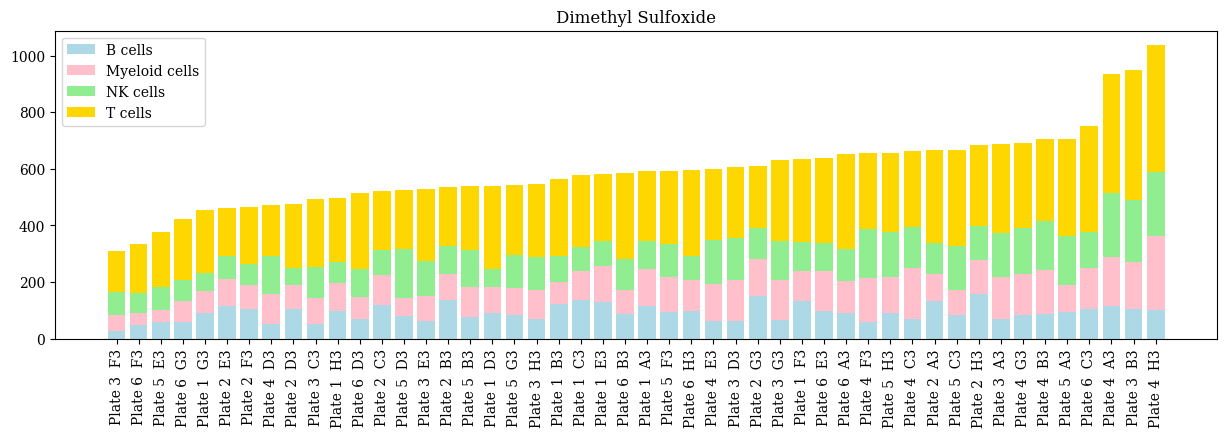

In [ ]:
plate_name_map = {'010':'Plate 1', '011':'Plate 2', '012':'Plate 3', '013':'Plate 4', '014':'Plate 5', '015':'Plate 6'}

for control_compound in controls3:
    df_subset = bulk_adata.obs[bulk_adata.obs.sm_name==control_compound]
    df_subset.plate_name = df_subset.plate_name.map(plate_name_map)
    df_subset['plate_name_well'] = df_subset['plate_name'].astype(str) + '  ' + df_subset['well'].astype(str)
    df_subset = df_subset[['plate_name_well', 'cell_type', 'cell_count']]

    df_subset = df_subset.pivot(index='plate_name_well', columns='cell_type', values='cell_count')
    df_subset['sum'] = df_subset.sum(axis=1)
    df_subset = df_subset.sort_values('sum')
    df_subset = df_subset.drop(columns='sum')
    plot_stacked_bar_chart(df_subset, title=control_compound, xticklabels=df_subset.index.values,  figsize=(15, 4))

## Missing counts

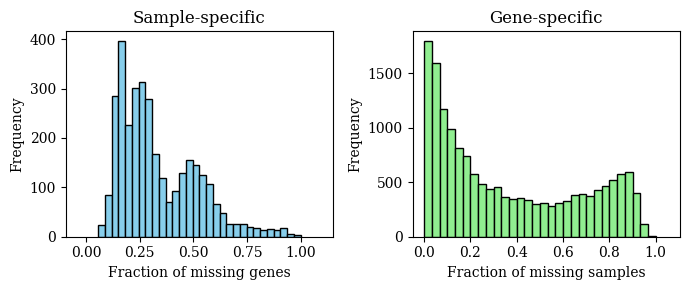

In [ ]:
def plot_bipartite(data):
    # Calculate sparsity for observations (samples)
    obs_sparsity = (data == 0).sum(axis=1)
    obs_sparsity = obs_sparsity/obs_sparsity.max()
    # Calculate sparsity for variables (genes)
    var_sparsity = (data == 0).sum(axis=0)
    var_sparsity = var_sparsity/var_sparsity.max()

    # Plot histograms for observations and variables
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    # Plot histogram for observation-specific sparsity
    ax = axs[0]
    ax.hist(obs_sparsity, bins=30, color='skyblue', edgecolor='black')
    ax.set_title('Sample-specific')
    ax.set_xlabel('Fraction of missing genes')
    ax.set_ylabel('Frequency')
    x_min, x_max = ax.get_xlim()
    x_margin = 0.1 * (x_max - x_min)
    ax.set_xlim(x_min-x_margin, x_max + x_margin)

    # Plot histogram for variable-specific sparsity
    ax = axs[1]
    ax.hist(var_sparsity, bins=30, color='lightgreen', edgecolor='black')
    ax.set_title('Gene-specific')
    ax.set_xlabel('Fraction of missing samples')
    ax.set_ylabel('Frequency')
    x_min, x_max = ax.get_xlim()
    x_margin = 0.05 * (x_max - x_min)
    ax.set_xlim(x_min, x_max + x_margin)

    return fig, axes

fig, axes = plot_bipartite(data=bulk_adata.X)
plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)
plt.show()


In [ ]:
missingness = (bulk_adata.X == 0).sum(axis=1)/bulk_adata.X.shape[1]
missingness

array([0.23462036, 0.15450459, 0.28302235, ..., 0.17827452, 0.39078761,
       0.46880966])

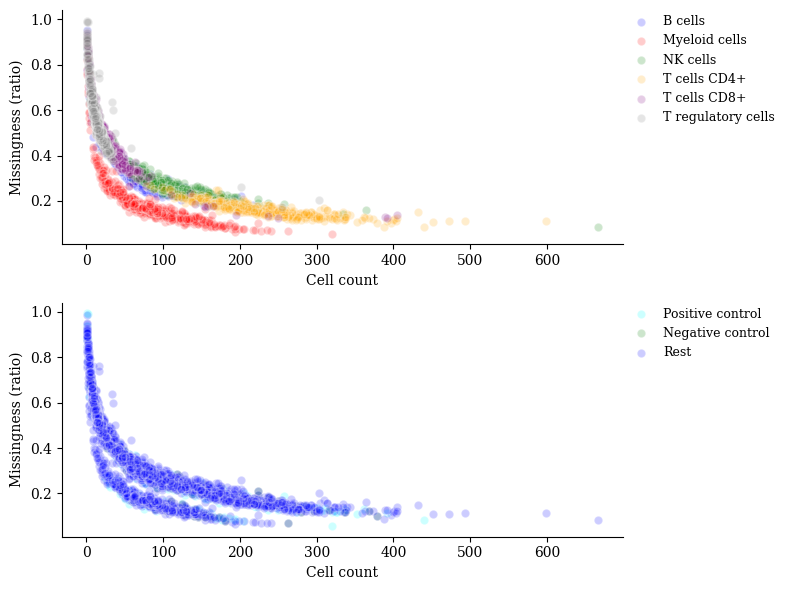

In [ ]:
xs = bulk_adata.obs.cell_count
ys = missingness


fig, axes = plot_scatter(bulk_adata_df, obs_index, xs, ys, x_label='Cell count', y_label='Missingness (ratio)', log=False, log_y=False, figsize=(8, 6))


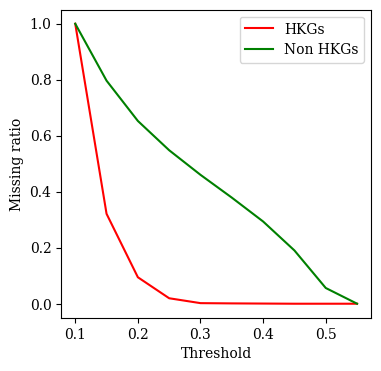

In [ ]:
# aqad
housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)
missingness = (bulk_adata.X==0).sum(axis=0)/bulk_adata.shape[0]
sum_count = bulk_adata.X.sum(axis=0)

ys = missingness

all_genes = bulk_adata.var.index.values
mask_hkgs = bulk_adata.var.index.isin(housekeeping_genes)
non_hkgs = all_genes[~mask_hkgs]

ratio_hkgs_list = []
ratio_nonhkgs_list = []
thresholds = np.arange(0,1,.1)
for tt in thresholds:
    mask = missingness>tt
    ratio_hkgs_list.append((mask_hkgs*mask).sum()/mask_hkgs.sum())
    ratio_nonhkgs_list.append(((~mask_hkgs)*mask).sum()/(~mask_hkgs).sum())
# plot
fig, ax = plt.subplots(1, 1, figsize=(4,4), sharey=False)
ax.plot(thresholds, ratio_hkgs_list, label='HKGs', color='red')
ax.plot(thresholds, ratio_nonhkgs_list, label='Non HKGs', color='green')
ax.set_xlabel('Threshold')
ax.set_ylabel('Missing ratio')
ax.set_xticklabels(np.round(thresholds,1))
ax.legend()

# Identification of potential outliers


In [ ]:
aa

## Misclassification of cell types

### Identification of the outlier compounds using histograms


In [ ]:
normalized_ratios = cell_count_m.div(cell_count_m.sum(axis=1), axis=0)
normalized_ratios.head()

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells,total
sm_name,,,,,,,
Alvocidib,0.029412,0.009804,0.058824,0.078431,0.000000,0.323529,0.5
CGP 60474,0.016304,0.000000,0.032609,0.081522,0.000000,0.369565,0.5
BMS-387032,0.007109,0.000000,0.231043,0.169431,0.011848,0.080569,0.5
UNII-BXU45ZH6LI,0.111369,0.032483,0.032483,0.298144,0.006961,0.018561,0.5
ABT737,0.009879,0.130626,0.090560,0.227223,0.022503,0.019210,0.5


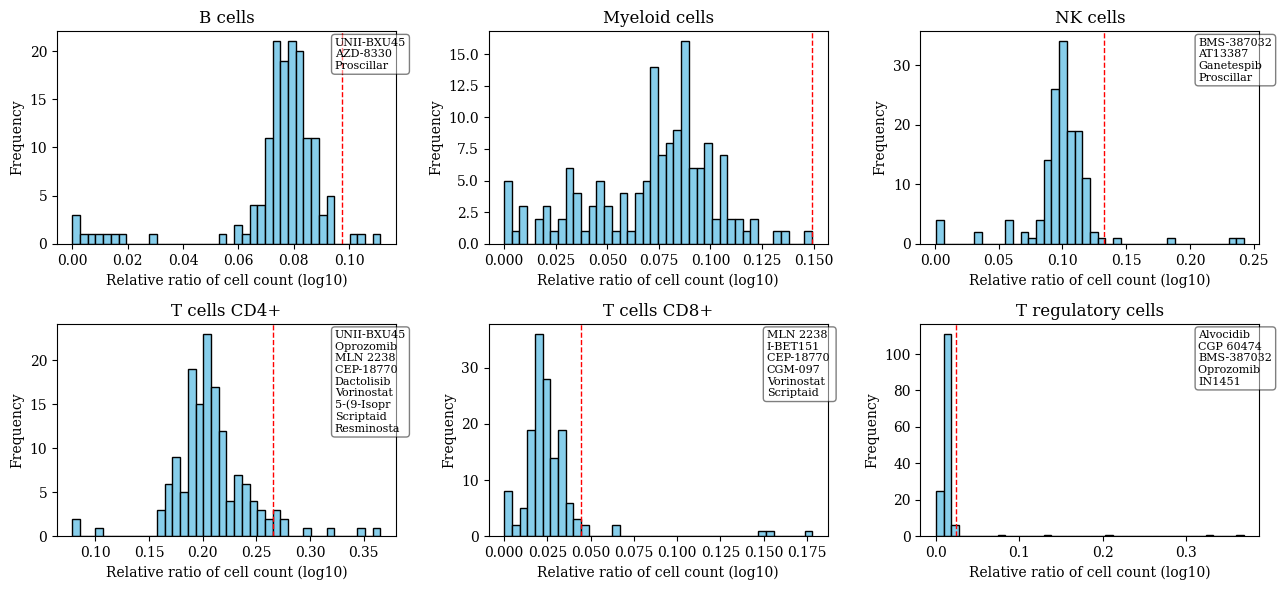

In [ ]:
from scipy.stats import median_abs_deviation
major_celltypes = []

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 6))
axes = axes.flatten()
threshold = 4
outliers_stack = []
# Iterate through each cell type to create histograms
for idx, cell_type in enumerate(cell_types):
    ax = axes[idx]
    data_celltype = normalized_ratios[cell_type]
    median_data = np.median(data_celltype)
    upper_bound_log = median_data + threshold*median_abs_deviation(data_celltype)
    ax.axvline(x=upper_bound_log, color='red', linestyle='--', linewidth=1)
    ax.hist(data_celltype, bins=40, label=cell_type, color='skyblue', edgecolor='black')
    ax.set_title(f'{cell_type}')
    ax.set_xlabel('Relative ratio of cell count (log10)')
    ax.set_ylabel('Frequency')

    if cell_type in major_celltypes:
        lower_bound_log =  median_data - threshold*median_abs_deviation(data_celltype)
        ax.axvline(x=lower_bound_log, color='green', linestyle='--', linewidth=1)
        exceeding_drugs = [drug for drug, value in data_celltype.items() if (value < lower_bound_log) or (value > upper_bound_log)]
    else:
        exceeding_drugs = [drug for drug, value in data_celltype.items() if (value > upper_bound_log)]

    outliers_stack+= exceeding_drugs
    if True:
        # annote outlier drugs
        exceeding_drugs = [item[0:10] if len(item)>10 else item for item in exceeding_drugs ]
        drugs_text = '\n'.join(exceeding_drugs)
        # Place the collected names in a box
        if exceeding_drugs:
            ax.text(0.82, 0.97, drugs_text, transform=ax.transAxes, fontsize=8, 
                    verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5,  facecolor='white'))
plt.tight_layout()
plt.show()


In [ ]:
outlier_compounds_1, counts_outliers = np.unique(outliers_stack, return_counts=True)
print(len(outlier_compounds_1))
outlier_compounds_1

19


array(['5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6-yl)pyrimidin-2-amine',
       'AT13387', 'AZD-8330', 'Alvocidib', 'BMS-387032',
       'CEP-18770 (Delanzomib)', 'CGM-097', 'CGP 60474', 'Dactolisib',
       'Ganetespib (STA-9090)', 'I-BET151', 'IN1451', 'MLN 2238',
       'Oprozomib (ONX 0912)', 'Proscillaridin A;Proscillaridin-A',
       'Resminostat', 'Scriptaid', 'UNII-BXU45ZH6LI', 'Vorinostat'],
      dtype='<U68')

### Identification of the outlier compounds using isolation forest analysis
This method uses isolation forest based on the cell count ratios to pinpoint outliers. See this tutorial for more information [https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py].

In [ ]:

def isolation_forest(df_subset):
    from sklearn.ensemble import IsolationForest
    cell_count_m = df_subset.pivot(index='index', columns='cell_type', values='cell_count')
    cell_count_ratio = cell_count_m.div(cell_count_m.sum(axis=1), axis=0)
    cell_count_ratio = cell_count_ratio.fillna(0)
    clf = IsolationForest(max_samples=100, random_state=0)
    clf.fit(cell_count_ratio.values)
    outlier_compounds = cell_count_ratio.index[clf.predict(cell_count_ratio.values)==-1]
    return outlier_compounds




CategoricalIndex(['Alvocidib', 'CGP 60474', 'BMS-387032', 'UNII-BXU45ZH6LI',
                  'ABT737', 'Oprozomib (ONX 0912)', 'MLN 2238', 'AT13387',
                  'CEP-18770 (Delanzomib)', 'Navitoclax', 'IN1451',
                  'ABT-199 (GDC-0199)', 'CGM-097', 'Vorinostat',
                  'Ganetespib (STA-9090)', 'Scriptaid',
                  'Proscillaridin A;Proscillaridin-A', 'LY2090314'],
                 categories=['5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin..., 'ABT737', 'ABT-199 (GDC-0199)', 'AMD-070 (hydrochloride)', ..., 'Vanoxerine', 'Vardenafil', 'Vorinostat', 'YK 4-279'], ordered=False, dtype='category', name='sm_name')

### Outlier compounds identified mutually by the two approaches
The combined results from the two methods are used to determine the outlier compounds. It's important to note that our analysis is confined to training cell types due to the limited number of samples available for test cell types.

In [ ]:
toGoCompound_1 = np.intersect1d(outlier_compounds_1, outlier_compounds_2)
print(f'# of compounds: {len(outlier_compounds_1)=}, {len(outlier_compounds_2)=}, {len(toGoCompound_1)=}')
toGoCompound_1

# of compounds: len(outlier_compounds_1)=19, len(outlier_compounds_2)=18, len(toGoCompound_1)=14


array(['AT13387', 'Alvocidib', 'BMS-387032', 'CEP-18770 (Delanzomib)',
       'CGM-097', 'CGP 60474', 'Ganetespib (STA-9090)', 'IN1451',
       'MLN 2238', 'Oprozomib (ONX 0912)',
       'Proscillaridin A;Proscillaridin-A', 'Scriptaid',
       'UNII-BXU45ZH6LI', 'Vorinostat'], dtype=object)

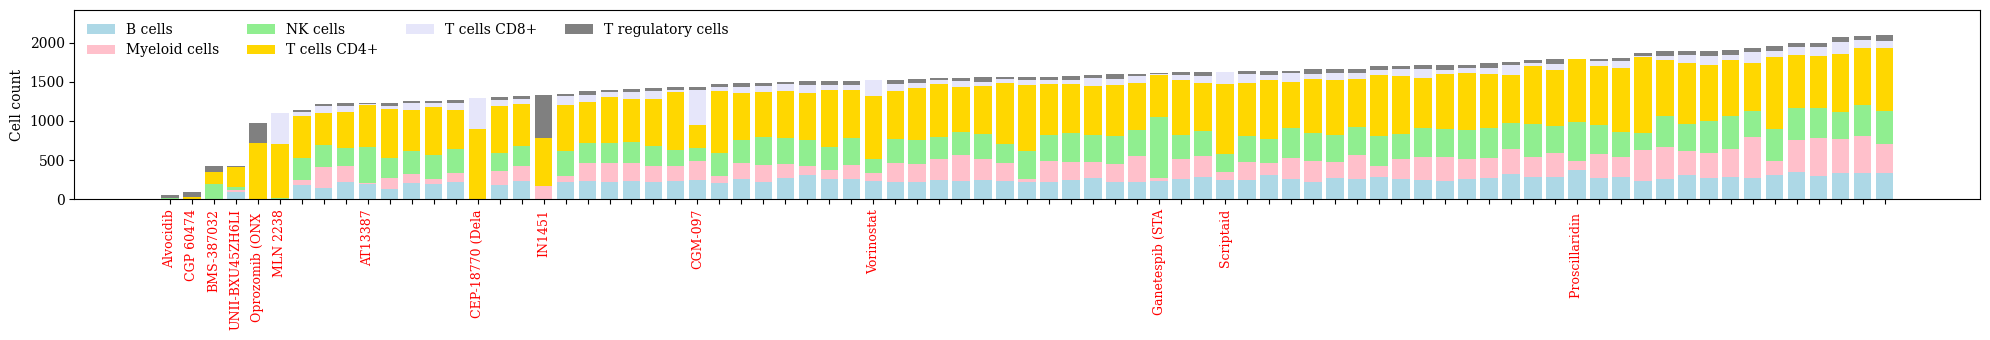

In [ ]:
# Plot for non controls
cc = cell_count_m.loc[~cell_count_m.index.get_level_values('sm_name').isin(controls3),:]

if True: # dont show all the compounds 
    outliers_df = cc.loc[cc.index.get_level_values('sm_name').isin(toGoCompound_1)]
    remaining_sm_names = cc.index.get_level_values('sm_name').difference(outliers_df.index.get_level_values('sm_name'))
    sampled_remaining = cc.loc[remaining_sm_names].sample(frac=0.5, random_state=42)
    cc = pd.concat([outliers_df, sampled_remaining])
    cc = cc.sort_values('total')
sorted_compound_names = cc.index
xticks = np.arange(len(cc))
xticklabels = sorted_compound_names
xticklabels_short = [label[0:20] for label in xticklabels]


colors = []

xticklabels_new = []
for label in xticklabels:
    if label in toGoCompound_1:
        xticklabels_new.append(label)
    else:
        xticklabels_new.append('')
    colors.append('red')
xticklabels = xticklabels_new  


xticklabels_short = [label[0:15] for label in xticklabels]

fig, ax = plot_stacked_bar_chart(cc[cell_types], '', xticks=xticks, xticklabels=xticklabels_short, colors=colors, figsize=(20,3.5))
ax.set_ylabel('Cell count')
# ax.add_artist(first_legend)
x_min, x_max = ax.get_ylim()
x_margin = 0.1 * (x_max - x_min)
ax.set_ylim(x_min, x_max + x_margin)

x_min, x_max = ax.get_xlim()
x_margin = 0 * (x_max - x_min)
ax.set_xlim(x_min, x_max - x_margin)
# ax.legend(title='Cell types', loc='left', bbox_to_anchor=(1, 0.5))
ax.legend(ncol=4, frameon=False, loc='upper left')
plt.xticks(fontsize=9)
plt.tight_layout()
# fig.savefig(f'{work_dir}/preprocess/figs/ambros_style_graph.png', dpi=100)


### Samples associated with the outlier compounds
All samples associated with the outlier compounds are identified here which will be removed from the data later.

In [ ]:
mask_toGoSamples_1 = pd.DataFrame(cell_count.index.get_level_values('sm_name').isin(toGoCompound_1), index=cell_count.index)
print(f'number of samples (grouped (sm_name, cell_type)) to go due to invalid cell type {mask_toGoSamples_1.sum()[0]}')

number of samples (grouped (sm_name, cell_type)) to go due to invalid cell type 78


## Samples with low cell count
In our earlier research (refer to [1]), we demonstrated that samples with low cell counts tend to exhibit abnormal DE values. We showed that those samples with 10 or less cells were noisy and potentially errorneous. Here, we identify those samples and associated compounds as outliers.

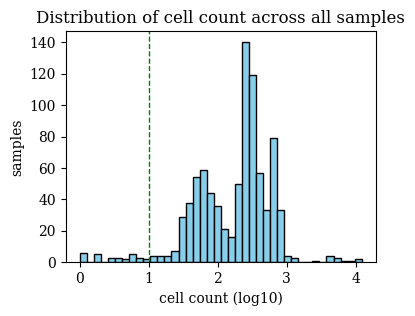

In [ ]:
lower_bound = 10
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
ax.hist(np.log10(cell_count.values), bins=40, label=cell_type, color='skyblue', edgecolor='black')
plt.xlabel('cell count (log10)')
plt.ylabel('samples')
plt.title('Distribution of cell count across all samples')
ax.axvline(x=np.log10(10), color='green', linestyle='--', linewidth=1)

In [ ]:
mask_toGoSamples_2 = (cell_count.values.ravel()<lower_bound)
print(f'Number of samples to go: {mask_toGoSamples_2.sum()}')

Number of samples to go: 27


In [ ]:
cell_count[mask_toGoSamples_2].index.get_level_values('sm_name').unique().shape


(14,)

In [ ]:
cell_count[mask_toGoSamples_2].index.get_level_values('cell_type').unique().shape

(6,)

## All samples to go

In [ ]:
toGoSamples_1 = mask_toGoSamples_1[mask_toGoSamples_1.values].reset_index()['sample'].values
toGoSamples_2 = mask_toGoSamples_2[mask_toGoSamples_2.values].reset_index()['sample'].values

print('if all outlier samples of 2 belong to 1? :', np.isin(np.intersect1d(toGoSamples_1, toGoSamples_2), toGoSamples_1).all())

if all outlier samples of 2 belong to 1? : True


In [ ]:
mask_toGoSamples_all = (mask_toGoSamples_1 | mask_toGoSamples_2)
print(f'Number of samples to go: {mask_toGoSamples_all.sum()[0]}')
mask_toGoSamples_all.head()

Number of samples to go: 145


0
sm_name                                            cell_type          sample                                                   
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... NK cells           5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6...  False
                                                   T cells CD4+       5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6...  False
                                                   T cells CD8+       5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6...  False
                                                   T regulatory cells 5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6...  False
ABT737                                             NK cells           ABT737__NK cells                                    False

# Filtering

In [ ]:
\\\

SyntaxError: unexpected character after line continuation character (4259107599.py, line 1)

## Filter outlier samples

In [ ]:
bulk_adata

AnnData object with n_obs × n_vars = 2558 × 18211
    obs: 'cell_type', 'col', 'sm_lincs_id', 'dose_uM', 'library_id', 'well', 'donor_id', 'SMILES', 'sm_name', 'timepoint_hr', 'control', 'cell_id', 'plate_name', 'row', 'cell_count', 'positive_control', 'negative_control'
    var: 'gene'

In [ ]:
df = bulk_adata_df.reset_index()
mask_df = mask_toGoSamples_all[mask_toGoSamples_all.values].reset_index()[['sm_name', 'cell_type']]
mask_filter = (df.sm_name.isin(mask_df.sm_name) & df.cell_type.isin(mask_df.cell_type))
print('number of samples to remove from bulk data: ', mask_filter.sum())

bulk_adata = bulk_adata[~mask_filter, :]
bulk_adata

number of samples to remove from bulk data:  1162


View of AnnData object with n_obs × n_vars = 1396 × 18211
    obs: 'cell_type', 'col', 'sm_lincs_id', 'dose_uM', 'library_id', 'well', 'donor_id', 'SMILES', 'sm_name', 'timepoint_hr', 'control', 'cell_id', 'plate_name', 'row', 'cell_count', 'positive_control', 'negative_control'
    var: 'gene'

In [ ]:
bulk_adata.write(f'{work_dir}/preprocess/bulk_adata_de_1.h5ad')

## Filtering genes with edgeR

In [ ]:
# anndata2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R -i work_dir -o filtered_data_edgR 
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)
bulk_adata_de_1 = readH5AD(paste0(work_dir, '/preprocess/bulk_adata_f_1.h5ad'))

filter_func <- function(adata_){
    d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name, genes=rownames(rowData(bulk_adata_f_1)))
    print("Dimensions before subsetting:")
    print(dim(d))
    keep <- filterByExpr(d)
    d <- d[keep, , keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(d))
    return (d)
}
filtered_data_edgR <-filter_func(bulk_adata_f_1)



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    Loading required package: limma
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAn

RInterpreterError: Failed to parse and evaluate line 'library(edgeR)\nlibrary(MAST)\nlibrary(zellkonverter)\noptions(max.print=100)\nbulk_adata_de_1 = readH5AD(paste0(work_dir, \'/preprocess/bulk_adata_f_1.h5ad\'))\n\nfilter_func <- function(adata_){\n    d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name, genes=rownames(rowData(bulk_adata_f_1)))\n    print("Dimensions before subsetting:")\n    print(dim(d))\n    keep <- filterByExpr(d)\n    d <- d[keep, , keep.lib.sizes=FALSE]\n    print("Dimensions after subsetting:")\n    print(dim(d))\n    return (d)\n}\nfiltered_data_edgR <-filter_func(bulk_adata_f_1)\n'.
R error message: "Error in h(simpleError(msg, call)) : \n  error in evaluating the argument 'x' in selecting a method for function 'assay': object 'bulk_adata_f_1' not found"
R stdout:
Loading required package: limma
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeightedVars

Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min

Loading required package: S4Vectors

Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: IRanges
Loading required package: GenomeInfoDb
Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Attaching package: ‘Biobase’

The following object is masked from ‘package:MatrixGenerics’:

    rowMedians

The following objects are masked from ‘package:matrixStats’:

    anyMissing, rowMedians


Attaching package: ‘SingleCellExperiment’

The following object is masked from ‘package:edgeR’:

    cpm

Registered S3 methods overwritten by 'zellkonverter':
  method                                             from      
  py_to_r.numpy.ndarray                              reticulate
  py_to_r.pandas.core.arrays.categorical.Categorical reticulate
Error in h(simpleError(msg, call)) : 
  error in evaluating the argument 'x' in selecting a method for function 'assay': object 'bulk_adata_f_1' not found
In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: Python '/root/.cache/R/basilisk/1.14.3/zellkonverter/1.12.1/zellkonverterAnnDataEnv-0.10.2/bin/python' was requested but '/root/anaconda3/envs/py10_2/bin/python' was loaded instead (see reticulate::py_config() for more information)

In [ ]:
filtered_data_edgR.keys()

('counts', 'samples', 'genes')

In [ ]:
assert 'genes' in filtered_data_edgR.keys()

In [ ]:
# genes suggested by figr
genes_edger = filtered_data_edgR['genes'].index
mask_genes_edger = bulk_adata.var.index.isin(genes_edger)
print(mask_genes_edger.sum())
# mask_genes_edger
# mask_genes_edger

15845


In [ ]:
bulk_adata = bulk_adata[:, mask_genes_edger]
bulk_adata

View of AnnData object with n_obs × n_vars = 3099 × 15845
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'split', 'dose_uM', 'positive_ctr', 'plate_name', 'well', 'sm_name', 'col', 'raw_cell_id', 'hashtag_id', 'cell_id', 'container_format', 'cell_type', 'timepoint_hr', 'cell_count'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'

## Genes and samples with low coverage

In [ ]:
gene_wise = (bulk_adata.X!=0).sum(axis=0)
sample_wise = (bulk_adata.X!=0).sum(axis=1)

threshold = 0.5

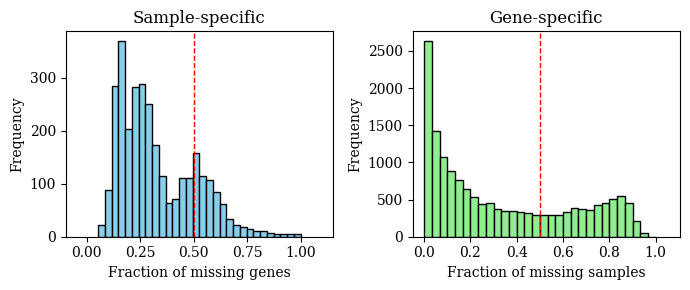

In [ ]:
fig, axes = plot_bipartite(data=bulk_adata.X)

fig.get_axes()[0].axvline(x=threshold, color='red', linestyle='--', linewidth=1)
fig.get_axes()[1].axvline(x=threshold, color='red', linestyle='--', linewidth=1)
plt.tight_layout()
# fig.savefig(f'{work_dir}/preprocess/figs/missigness.png', dpi=150, transparent=True)
plt.show()

In [ ]:
bulk_adata = bulk_adata[(sample_wise/gene_wise.size)>threshold,(gene_wise/sample_wise.size)>threshold]

In [ ]:
bulk_adata

View of AnnData object with n_obs × n_vars = 2619 × 11297
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'split', 'dose_uM', 'positive_ctr', 'plate_name', 'well', 'sm_name', 'col', 'raw_cell_id', 'hashtag_id', 'cell_id', 'container_format', 'cell_type', 'timepoint_hr', 'cell_count'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'

## Samples to go due to insufficient cell types left
If we remove problamatic samples, lets check the cell types left for each drug.

In [ ]:
df = bulk_adata.obs.groupby('sm_name').apply(lambda df: df['cell_type'].unique())
# should be either B cells or Myeloid cells remaining 
mask_1 = np.asarray([('B cells' in item) or ('Myeloid cells' in item) for item in df.values])
print('to go compounds: ', (~mask_1).sum())
# should have at least 4 cell types left
mask_2 = np.asarray([len(item)>=4 for item in df.values])
print('to go compounds: ', (~mask_2).sum())

to go compounds:  0
to go compounds:  0


In [ ]:
# compounds to keep
to_keep_compounds = df.index.values[mask_1*mask_2]
to_keep_compounds.shape

(131,)

In [ ]:
# apply actual filtering
bulk_adata = bulk_adata[bulk_adata.obs.sm_name.isin(to_keep_compounds),:]
bulk_adata

View of AnnData object with n_obs × n_vars = 2619 × 11297
    obs: 'plate_well_cell_type', 'donor_id', 'row', 'split', 'dose_uM', 'positive_ctr', 'plate_name', 'well', 'sm_name', 'col', 'raw_cell_id', 'hashtag_id', 'cell_id', 'container_format', 'cell_type', 'timepoint_hr', 'cell_count'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'

In [ ]:
(bulk_adata.X.flatten()==0).sum()/bulk_adata.X.flatten().size

0.09867463723655816

In [ ]:
bulk_adata.obs.reset_index(drop=True, inplace=True)
# bulk_adata.var.reset_index(drop=True, inplace=True)

In [ ]:
print('compounds left:', bulk_adata.obs.sm_name.unique().shape)

compounds left: (131,)


collection

compounds left: (132,)

In [ ]:
# save filtered adata
bulk_adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')

In [ ]:
aa

NameError: name 'aa' is not defined

# EDA after filtering

In [ ]:
bulk_adata_f = ad.read(f'{work_dir}/preprocess/bulk_adata_f.h5ad')

## Distribution of pseudobulkd samples 

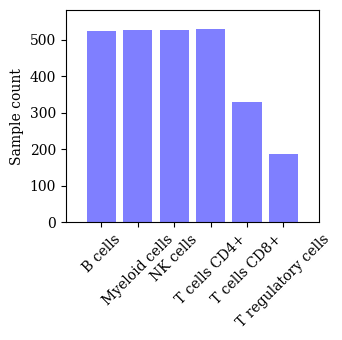

In [ ]:
samples_counts = bulk_adata_f.obs.groupby('cell_type').size().to_dict()

fig, ax = plt.subplots(1,1 , figsize=(3.5, 3.5))  # Adjust the figure size as needed
ax.bar(samples_counts.keys(), samples_counts.values(), color='blue', alpha=0.5)
ax.set_ylabel('Sample count')
ax.margins(0.1)
plt.tick_params('x', rotation=45)
plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/celltype_raios.png', dpi=100, transparent=True)
plt.show()

In [ ]:
samples_counts

{'B cells': 522,
 'Myeloid cells': 526,
 'NK cells': 527,
 'T cells CD4+': 528,
 'T cells CD8+': 328,
 'T regulatory cells': 188}

## Distribution of pseudobulkd samples per compound

In [ ]:
sample_n = bulk_adata_f.obs.groupby(['cell_type', 'sm_name']).size().unstack('cell_type')
sample_n.fillna(0, inplace=True) # fill nans and sort for train cell type

sample_n['total'] = sample_n.sum(axis=1) # Sort by the four training cell types
sample_n.sort_values('total', inplace=True)
sample_n.tail()

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells,total
sm_name,,,,,,,
Masitinib,3,3,3,3,3,3,18
Protriptyline,3,3,3,3,3,3,18
Belinostat,48,48,47,48,8,0,199
Dabrafenib,48,48,48,48,34,13,239
Dimethyl Sulfoxide,48,48,48,48,30,26,248


128


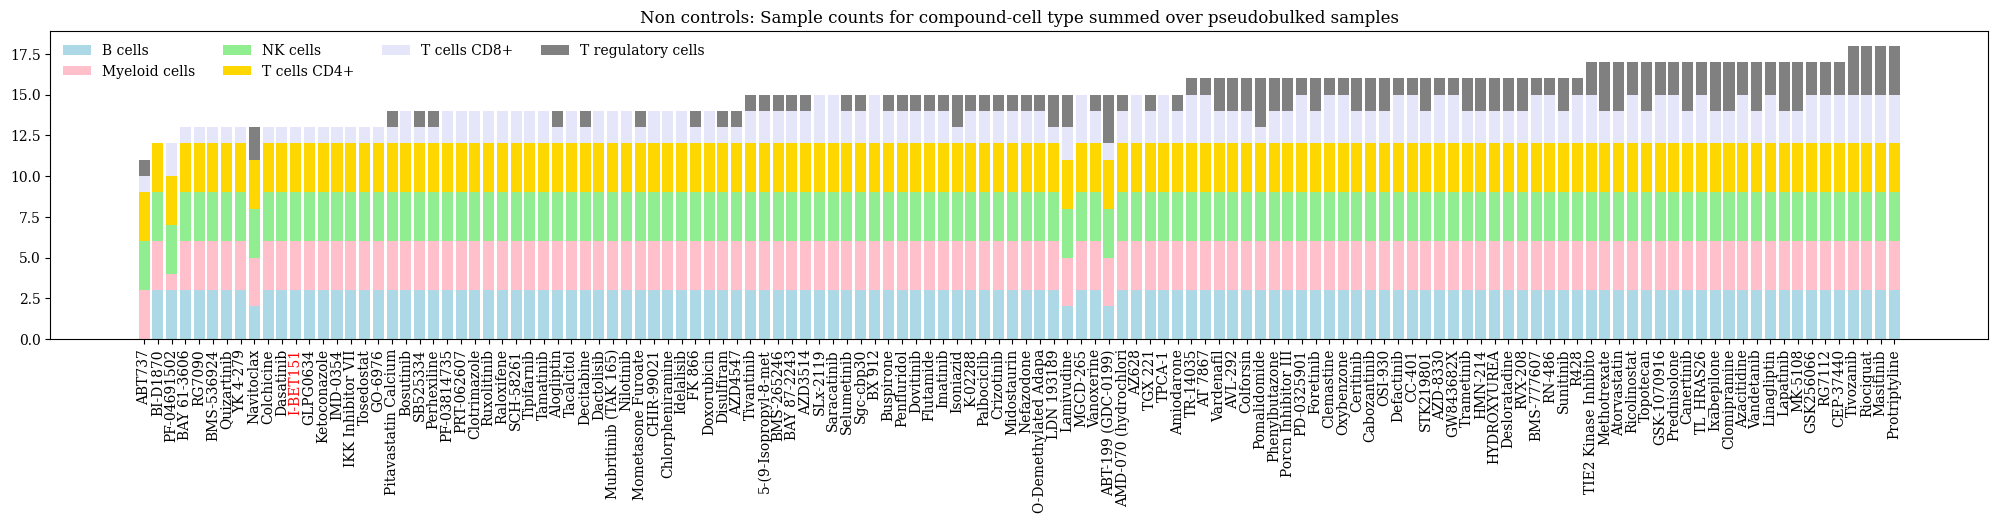

In [ ]:
# Plot for non controls
cc = sample_n.loc[~sample_n.index.isin(controls3),:]
sorted_compound_names = cc.index

if False: # selective x lables
    xticks = np.arange(len(cc))[sorted_compound_names.isin(all_outliers)]
    xticklabels = sorted_compound_names[sorted_compound_names.isin(all_outliers)]
else:
    xticks = np.arange(len(cc))
    xticklabels = sorted_compound_names
xticklabels = [label[0:20] for label in xticklabels]
print(len(xticklabels))
colors = []
for i, sm_name in enumerate(xticklabels):
    if sm_name in outliers_me:
        colors.append('red')
    else:
        colors.append('black')

fig, ax = plot_stacked_bar_chart(cc[cell_types], 'Non controls: Sample counts for compound-cell type summed over pseudobulked samples', xticks=xticks, xticklabels=xticklabels, colors=colors, figsize=(25, 4))
ax.legend(ncol=4, frameon=False, loc='upper left')


collection

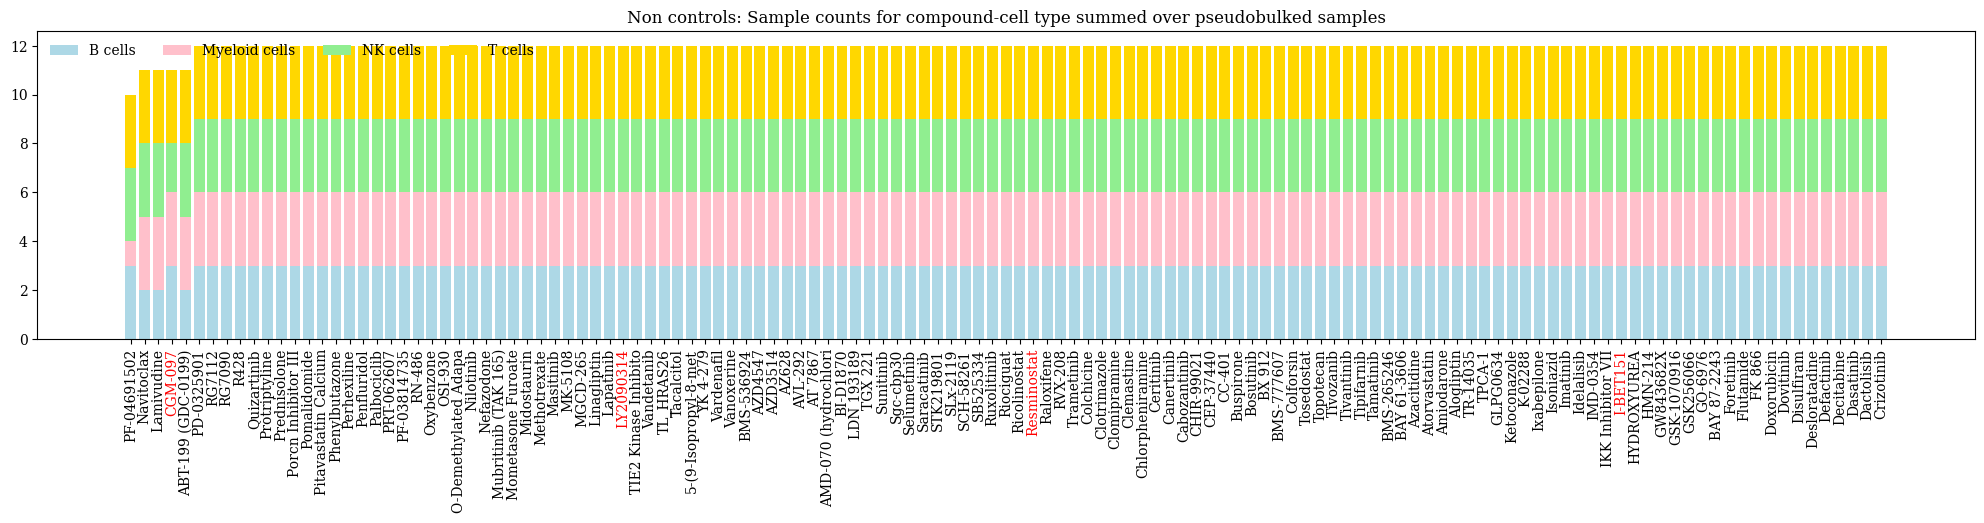

## Donor-specific cell type ratio 

In [ ]:
donor_cellcounts = bulk_adata_f.obs.groupby('donor_id').apply(lambda df:df.groupby('cell_type').apply(lambda df2: df2['cell_count'].sum()))
donor_samplesize = bulk_adata_f.obs.groupby('donor_id').apply(lambda df:df.groupby('cell_type').size())
donor_samplesize_n = donor_samplesize/donor_cellcounts
adj_coeff = 1/(donor_samplesize/donor_cellcounts).sum(axis=1)
donor_samplesize_n = donor_samplesize_n.mul(adj_coeff, axis=0)
donor_samplesize_n

cell_type,B cells,Myeloid cells,NK cells,T cells CD4+,T cells CD8+,T regulatory cells
donor_id,,,,,,
Donor 1,0.065949,0.095939,0.097924,0.036086,0.303055,0.401046
Donor 2,0.143053,0.085468,0.064001,0.042168,0.273561,0.391750
Donor 3,0.122080,0.116892,0.090802,0.039173,0.173331,0.457723


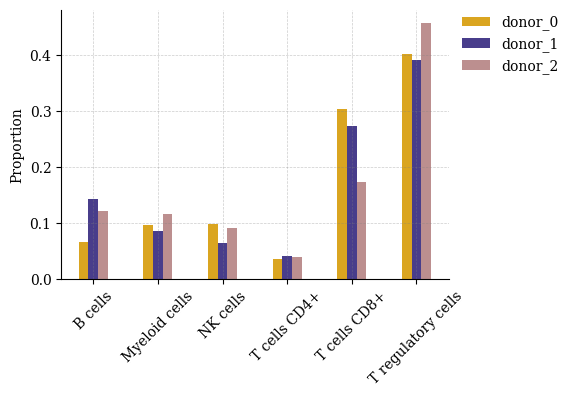

In [ ]:
plt.figure(figsize=(5, 3.5))
ax = plt.subplot(1, 1, 1)
width = 0.15
BOUNDS = {'NK cells': (0.03, 0.18), 'T cells CD4+': (0.33, 0.51), 'T cells CD8+': (0.16, 0.26), 'T regulatory cells': (0.01, 0.05), 'Myeloid cells': (0.11, 0.22), 'B cells': (0.03, 0.09)}

for i in range(3):
    color = ['goldenrod', 'darkslateblue', 'rosybrown'][i]
    proportions = donor_samplesize_n.iloc[i,:]
    plt.bar(np.arange(len(cell_types))-0.15+0.15*i, proportions, label=f'donor_{i}', width=width, color=color)
plt.xticks(np.arange(len(cell_types)), cell_types, rotation=45)
plt.ylabel('Proportion')
ax.spines[['right', 'top']].set_visible(False)
plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
plt.legend( bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
plt.show()

collection

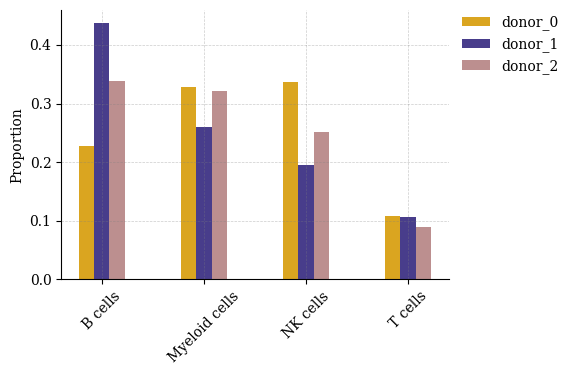

## Highly variable genes

In [ ]:
n_hvgs = 3000

In [ ]:
aba

NameError: name 'aba' is not defined

In [ ]:
%%R -i work_dir # run this from terminal 
library(scry)
library(zellkonverter)
library(SingleCellExperiment)

adata = readH5AD(paste0(work_dir, "/preprocess/bulk_adata_f.h5ad")) # raw counts
sce = scry::devianceFeatureSelection(adata, assay="X")
writeH5AD(sce, paste0(work_dir, "/preprocess/adata_sce.h5ad"))

In [ ]:
adata_sce = ad.read(f"{work_dir}/preprocess/adata_sce.h5ad")
binomial_deviance  = adata_sce.var['binomial_deviance']
indices = binomial_deviance.argsort()[-n_hvgs:]
mask = np.zeros(adata_sce.var.shape[0], dtype=bool)
mask[indices] = True
hvgs_sce = adata_sce[:, mask].var.index.values

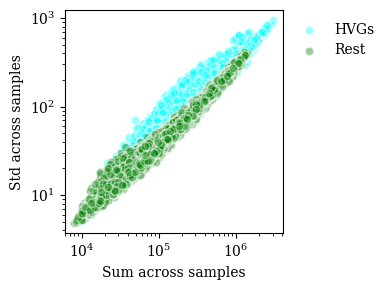

In [ ]:
genes = hvgs_sce
adata_f = bulk_adata_f
fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)    
var = adata_f.var
var['sum'] = adata_f.X.sum(axis=0)
var['std'] = adata_f.X.std(axis=0)
mask = var.index.isin(genes)
ax.scatter(var['sum'][mask], var['std'][mask], label='HVGs', alpha=0.4, color='cyan', edgecolors='white')
ax.scatter(var['sum'][~mask], var['std'][~mask], label='Rest', alpha=0.4, color='Green', edgecolors='white')


ax.set_ylabel('Std across samples')
ax.set_xlabel('Sum across samples')
ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(title='', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

plt.tight_layout()
fig.savefig(f'{work_dir}/benchmark/figs/hvgs_sum_std.png', dpi=150, transparent=True)

In [ ]:
housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)
all_genes = bulk_adata_f.var.index.values
mask_hkgs = bulk_adata_f.var.index.isin(housekeeping_genes)
non_hkgs = all_genes[~mask_hkgs]
non_hkgs.shape

(9386,)

In [ ]:
hvgs = hvgs_sce
genesets_dict = {'HKGs':housekeeping_genes, 'Rest': non_hkgs}
hvgs_intersection_n_dict = {}
hvgs_intersection_ratio_dict = {}
top_p_dict = {} # top percentile score versus randomly selected genes with the same dimension
n_random = 1000
for name, geneset in genesets_dict.items():
    shared_genes = np.intersect1d(geneset, all_genes)
    shared_hvgs_n = len(np.intersect1d(hvgs, shared_genes))
    shared_hvgs_ratio = shared_hvgs_n/len(shared_genes)

    hvgs_intersection_n_dict[name] = shared_hvgs_n
    hvgs_intersection_ratio_dict[name] = shared_hvgs_ratio

    # to percentile
    random_ratios = []
    for i in range(n_random):
        random_genes = np.random.choice(all_genes, shared_hvgs_n)
        random_ratios.append(len(np.intersect1d(hvgs, random_genes))/shared_hvgs_n)
    top_p = (np.asarray(random_ratios)>shared_hvgs_ratio).sum()/n_random
    top_p_dict[name] = top_p
print(f'{hvgs_intersection_ratio_dict=} \n {top_p_dict=}')

hvgs_intersection_ratio_dict={'HKGs': 0.151801535735381, 'Rest': 0.26486256126145324} 
 top_p_dict={'HKGs': 1.0, 'Rest': 0.0}


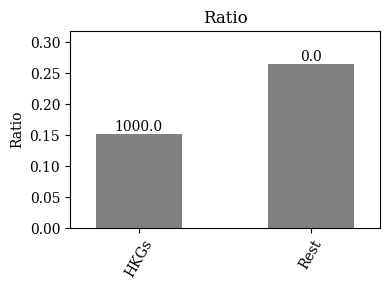

In [ ]:
hvgs = hvgs_sce

fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey=False)

def plot_bar(ax, data, y_label, title, top_p_dict=None):
    x_range = [x for x in range(len(data))]
    y_values = list(data.values())
    ax.bar(x_range, y_values, width=width, color='grey')
    ax.set_xticks(x_range)
    ax.set_xticklabels(data.keys())
    ax.tick_params(axis='x', rotation=60)
    ax.set_title(title)
    ax.margins(x=.1, y=.2)
    ax.set_ylabel(y_label)
    if top_p_dict is None:
        return 
    for i_text, value in enumerate(top_p_dict.values()):
        # if value < 0.0001:
        #     txt = '***'
        # if value < 0.001:
        #     txt = '**'
        # elif value < 0.01:
        #     txt = '*'
        # else:
        #     txt = ''
        txt = f'{value*1000}'
        ax.text(x_range[i_text], y_values[i_text], txt, ha='center', va='bottom')

width = .5

plot_bar(ax,  hvgs_intersection_ratio_dict, y_label='Ratio', title='Ratio', top_p_dict=top_p_dict)

plt.tight_layout()
plt.show()
# fig.savefig(f'{work_dir}/benchmark/figs/hvgs_stats.png', dpi=150, transparent=True)

# Normalize

In [ ]:
bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_bulk_data_def.h5ad')
bulk_adata_bulk_data_def.layers['counts'] = bulk_adata_f.X
bulk_adata_de

AnnData object with n_obs × n_vars = 2117 × 12772
    obs: 'plate_well_cell_type', 'col', 'plate_name', 'split', 'positive_ctr', 'container_format', 'cell_id', 'raw_cell_id', 'row', 'cell_type', 'hashtag_id', 'sm_name', 'dose_uM', 'well', 'donor_id', 'timepoint_hr', 'cell_count'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'
    layers: 'counts'

In [ ]:
assert (bulk_adata_de.X.flatten()==0).sum()/bulk_adata_de.X.flatten().size>0
# assert type(bulk_adata_de.X.flatten()[0])==int

## Scanpy shifted algorithm

In [ ]:
from sklearn.impute import KNNImputer
def knn_imputer(adata):
    imputer = KNNImputer(n_neighbors=10)
    data = adata.X
    mask = data==0
    data[mask] = np.nan
    adata.X = imputer.fit_transform(data)

adata = bulk_adata_de.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata)
# print(adata.var.highly_variable.sum())
# if True:
    
#     knn_imputer(adata)
    # sce.pp.magic(adata, knn=20, n_pca=20, solver='exact')
    # sc.pp.log1p(adata)
    # sc.pp.scale(adata)

    # sc.pp.highly_variable_genes(adata)
    # print('HVGs', adata.var.highly_variable.sum())
adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata_de_n_shifted_algorithm.h5ad')

In [ ]:
(adata.X.flatten()==0).sum()/adata.X.flatten().size

0.1016425426368883

In [ ]:
if False:
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var.highly_variable]
    print('HVGs', adata.var.highly_variable.sum())

## Scanpy pearson residuals
The third normalization technique we are introducing in this chapter is the analytic approximation of Pearson residuals. This normalization technique was motivated by the observation that cell-to-cell variation in scRNA-seq data might be confounded by biological heterogeneity with technical effects. The method utilizes Pearson residuals from ‘regularized negative binomial regression’ to calculate a model of technical noise in the data. 

In [ ]:

adata = bulk_adata_f.copy()
sc.experimental.pp.normalize_pearson_residuals(adata)
adata.write_h5ad(f'{work_dir}/preprocess/bulk_adata_f_n_pearson.h5ad')


# EDA on normalized data

In [ ]:
norm_tag = 'n_shifted_algorithm' # n_shifted_algorithm, n_pearson
adata_n = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f_{norm_tag}.h5ad')
obs_index = ['cell_type','sm_name']
adata_index = ['sm_name', 'cell_type', 'plate_name', 'row', 'donor_id']

adata = adata_n.copy()

adata_df = pd.DataFrame(adata.X, index= pd.MultiIndex.from_frame(adata.obs[adata_index]))
sum_count = adata_df.sum(axis=1)
cell_count = adata.obs.groupby(bulk_index).apply(lambda df:df['cell_count'].sum()).reindex_like(adata_df)
non_missing_count = (adata_df!=0).sum(axis=1)
top_quantile = (adata_df>adata_df.quantile(.95, axis=0)).sum(axis=1)/adata_df.shape[1]

if False:
    std = np.std(np.abs(adata_df), axis=1)
else:
    std = []
    for index, row in adata_df.iterrows():
        std.append(np.std(row[row!=0]))
    std = pd.DataFrame(std, index=adata_df.index)
print('sparsity', (adata.X.flatten()==0).sum()/adata.X.flatten().size)

sparsity 0.1016425426368883


## Normality

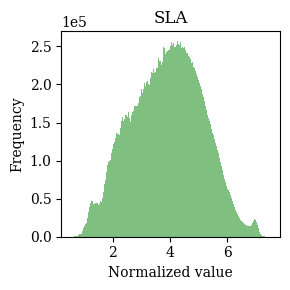

In [ ]:
import matplotlib.pyplot as plt

# Define colors
color = 'green'

# Create figure and axis
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharey=False)

# Plot histogram
data = adata.X.flatten()
data = data[data!=0]
ax.hist(data, bins=200, color=color, alpha=.5)

# Set axis labels and title
ax.set_xlabel('Normalized value')
ax.set_ylabel('Frequency')
if norm_tag == 'n_pearson':
    ax.set_xlim([-11,11])
    title = 'APR'
elif norm_tag == 'n_shifted_algorithm':
    title = 'SLA'
ax.ticklabel_format(axis='y', style='sci', useOffset=True, useMathText=False, scilimits=(0,0))  # Change 'plain' to 'sci' for scientific notation
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_yscale('log')
# Add margin to the plot
# ax.margins(0.05)
ax.set_title(title)
plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/norm_values_hist_{norm_tag}.png', dpi=100)
# Show plot
# plt.show()



## Std

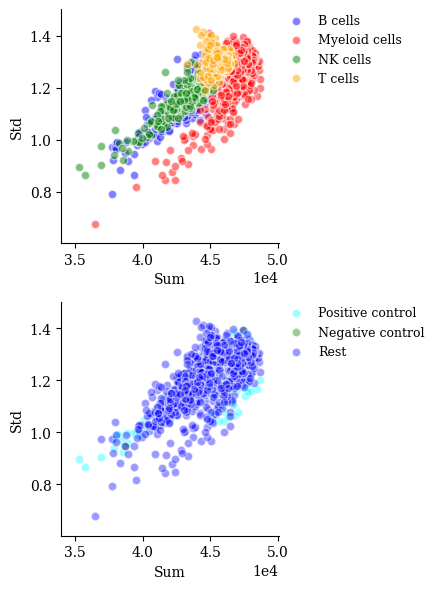

In [ ]:
xs = sum_count
ys = std

fig, axes = plot_scatter(adata_df, obs_index, xs, ys, x_label='Sum', y_label='Std', log=False, figsize=(4.5,6))
for ax in axes:
    ax.margins(0.1)
    ax.ticklabel_format(axis='x', style='sci', useOffset=True, useMathText=False, scilimits=(0,0))  # Change 'plain' to 'sci' for scientific notation

plt.tight_layout()
fig.savefig(f'{work_dir}/preprocess/figs/std_sum_nomalized_{norm_tag}.png', dpi=100)

## Top quantile 

(<Figure size 500x700 with 2 Axes>,
 array([<Axes: xlabel='Count sum', ylabel='Ratio of top quantile (0.95)'>,
        <Axes: xlabel='Count sum', ylabel='Ratio of top quantile (0.95)'>],
       dtype=object))

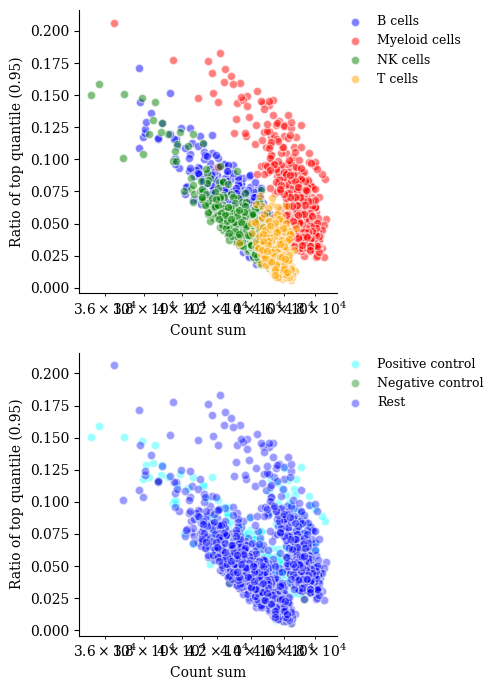

In [ ]:
ys = top_quantile
xs = sum_count

plot_scatter(adata_df, obs_index, xs, ys, x_label='Count sum', y_label='Ratio of top quantile (0.95)', log=True)

## Clusters

In [ ]:
adata_n_c = adata_n.copy()
with warnings.catch_warnings():
    sc.tl.pca(adata_n_c, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(adata_n_c, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata_n_c)

In [ ]:
map_names = {'donor_0':'Donor 1', 'donor_1': 'Donor 2', 'donor_2': 'Donor 3'} 
# adata_n_c.obs['Donor'] = adata_n_c.obs.donor_id.map(map_names)
adata_n_c.obs['Cell type'] = adata_n_c.obs.cell_type

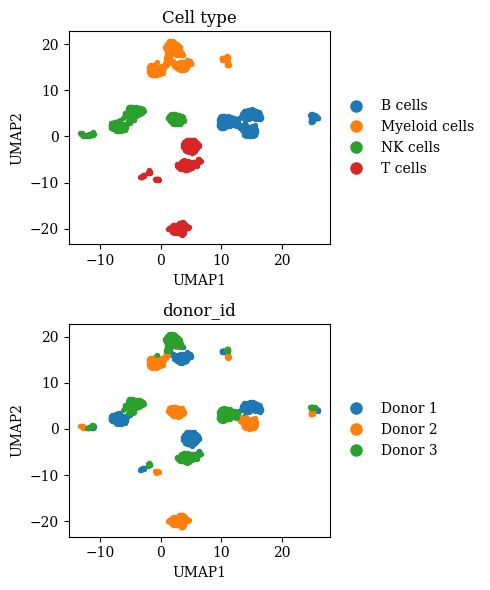

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

def cluster_plot(adata, var, ax):
    dim_data = adata.obsm['X_umap']
    legend_handles = []  
    var_unique = sorted(adata.obs[var].unique())  
    var_unique_sorted = sorted(var_unique)  
    for sub_var in var_unique_sorted:
        mask = adata.obs[var] == sub_var
        sub_data = dim_data[mask]
        scatter = ax.scatter(sub_data[:, 0], sub_data[:, 1], label=sub_var, s=8)
        legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=8, color=scatter.get_facecolor()[0]))

    ax.legend(handles=legend_handles, labels=var_unique_sorted, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.set_title(var)

for i_ax, var in enumerate(['Cell type', 'donor_id']): 
    cluster_plot(adata_n_c, var, axes[i_ax])

plt.tight_layout()

fig.savefig(f'{work_dir}/preprocess/figs/normalized_cluster_{norm_tag}.png', dpi=150, transparent=True)
plt.show()

In [ ]:
aa 

NameError: name 'aa' is not defined

# DE analysis using EdgeR

In [ ]:
bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')


# bulk_adata_f.var = bulk_adata_f.var.set_index('gene')
if True: #only hvgs
    hvgs = hvgs_sce
    bulk_data_de = bulk_adata_f[:, bulk_adata_f.var_names.isin(hvgs)]
else:
    bulk_data_de = bulk_adata_f
bulk_data_de

View of AnnData object with n_obs × n_vars = 2117 × 3000
    obs: 'plate_well_cell_type', 'col', 'plate_name', 'split', 'positive_ctr', 'container_format', 'cell_id', 'raw_cell_id', 'row', 'cell_type', 'hashtag_id', 'sm_name', 'dose_uM', 'well', 'donor_id', 'timepoint_hr', 'cell_count'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'

### <a id='toc6_1_1_'></a>[Format adata](#toc0_)

In [ ]:
compound_name_col = 'sm_name'

# sm_name
unique_sm_name = bulk_data_de.obs.sm_name.unique()
sm_name_map = {sm_name:f'sm_name_{number}' for sm_name, number in zip(unique_sm_name, range(len(unique_sm_name)))}
sm_name_s_map = {value: key for key, value in sm_name_map.items()}
# cell type
unique_cell_type = bulk_data_de.obs.cell_type.unique()
cell_type_map = {cell_type:f'celltype_{number}' for cell_type, number in zip(unique_cell_type, range(len(unique_cell_type)))}
cell_type_s_map = {value: key for key, value in cell_type_map.items()}
bulk_data_de.obs['sm_name_s'] = bulk_data_de.obs['sm_name'].map(sm_name_map).astype(str)
bulk_data_de.obs['cell_type_s'] = bulk_data_de.obs['cell_type'].map(cell_type_map)
negative_control_s = sm_name_map[negative_control] 

bulk_data_de.var = bulk_data_de.var.reset_index()

bulk_data_de

AnnData object with n_obs × n_vars = 2117 × 3000
    obs: 'plate_well_cell_type', 'col', 'plate_name', 'split', 'positive_ctr', 'container_format', 'cell_id', 'raw_cell_id', 'row', 'cell_type', 'hashtag_id', 'sm_name', 'dose_uM', 'well', 'donor_id', 'timepoint_hr', 'cell_count', 'sm_name_s', 'cell_type_s'
    var: 'index', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'ribo', 'hb'

In [ ]:

bulk_data_de.write(f'{work_dir}/de_analysis/edger/bulk_data_de.h5ad')

## Voom and lmfit

In [ ]:
%%time
%%R  -i work_dir -i negative_control_s -o topGenesList
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)

# bulk_data_de = readH5AD(paste0(work_dir, "/de_analysis/edger/bulk_data_de.h5ad"))

# adata_ <- bulk_data_de
# d <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name_s, genes=rowData(adata_)$index, samples=colData(adata_)$sm_name_s)
# print("Dimensions before subsetting:")
# print(dim(d))
# d <- calcNormFactors(d)
# group <- paste0(colData(adata_)$sm_name_s, ".", colData(adata_)$cell_type_s)
# # group <- colData(adata_)$sm_name_s
# plate_name <- colData(adata_)$plate_name
# row <- colData(adata_)$row
# design <- model.matrix(~ 0 + group + plate_name + row)
# print("Dimensions of design matrix:")
# print(dim(design))
# y <- voom(d, design, plot=TRUE)

# vfit <- lmFit(y, design) 


topGenesList <- list()
for(compound in unique(colData(bulk_data_de)$sm_name_s)) {
  for(celltype in unique(colData(bulk_data_de)$cell_type_s)) {
    treatment = sprintf("group%s.%s", compound, celltype)
    ctr = sprintf("group%s.%s", negative_control_s, celltype)
    if (!(treatment %in% colnames(design))){
      print(sprintf("%s doesnt exists", treatment))
    }
    else if ((treatment == ctr)){
      print("pass")
    }
    else{
    print(sprintf("%s running", treatment))
    contrast_name <- sprintf("%s - %s", treatment, ctr)
    # Create the contrast matrix
    contrastMatrix <- makeContrasts(contrasts=contrast_name, levels=design)
    
    fit2 <- contrasts.fit(vfit, contrastMatrix)
    fit2 <- eBayes(fit2)
    
    topGenes <- topTable(fit2, adjust="fdr", sort.by="P", number=Inf)
    topGenesList[[paste(compound, celltype, sep=".")]] <- topGenes
    }
  }
}

[1] "groupsm_name_0.celltype_0 running"
[1] "groupsm_name_0.celltype_1 running"


[1] "groupsm_name_0.celltype_2 running"
[1] "groupsm_name_0.celltype_3 running"
[1] "groupsm_name_1.celltype_0 running"
[1] "groupsm_name_1.celltype_1 running"
[1] "groupsm_name_1.celltype_2 running"
[1] "groupsm_name_1.celltype_3 running"
[1] "groupsm_name_2.celltype_0 running"
[1] "groupsm_name_2.celltype_1 running"
[1] "groupsm_name_2.celltype_2 running"
[1] "groupsm_name_2.celltype_3 running"
[1] "groupsm_name_3.celltype_0 running"
[1] "groupsm_name_3.celltype_1 running"
[1] "groupsm_name_3.celltype_2 running"
[1] "groupsm_name_3.celltype_3 running"
[1] "groupsm_name_4.celltype_0 running"
[1] "groupsm_name_4.celltype_1 running"
[1] "groupsm_name_4.celltype_2 running"
[1] "groupsm_name_4.celltype_3 running"
[1] "pass"
[1] "pass"
[1] "pass"
[1] "pass"
[1] "groupsm_name_6.celltype_0 running"
[1] "groupsm_name_6.celltype_1 running"
[1] "groupsm_name_6.celltype_2 running"
[1] "groupsm_name_6.celltype_3 running"
[1] "groupsm_name_7.celltype_0 running"
[1] "groupsm_name_7.celltype_1 runni

In [ ]:
df_de_stack = []
for key, df in topGenesList.items():
    sm_name_s, cell_type_s = key.split('.')
    sm_name = sm_name_s_map[sm_name_s]
    cell_type = cell_type_s_map[cell_type_s]
    df.sort_values('genes', inplace=True)
    
    df['sm_name'] = sm_name
    df['cell_type'] = cell_type

    df = df.set_index(['sm_name', 'cell_type'])
    df_de_stack.append(df)

In [ ]:
df_de = pd.concat(df_de_stack, axis=0)
df_de['sign_log10_pval'] = np.sign(df_de['logFC']) * -np.log10(df_de['adj.P.Val'])

In [ ]:
de_train_t = df_de.pivot(columns='genes', values='t')
de_train_t.columns.name = None
de_train = df_de.pivot(columns='genes', values='sign_log10_pval')
de_train.columns.name = None
de_train_p = df_de.pivot(columns='genes', values='adj.P.Val')
de_train_p.columns.name = None

In [ ]:
de_train_t.shape

(524, 3000)

### <a id='toc6_2_1_'></a>[Save](#toc0_)

In [ ]:
de_train_t.to_parquet(f'{out_edger_dir}/de_train_t.parquet')
de_train.to_parquet(f'{out_edger_dir}/de_train.parquet')
de_train_p.to_parquet(f'{out_edger_dir}/de_train_p.parquet')

## 

In [ ]:
%%R -i main_dir
library(edgeR)
library(MAST)
library(zellkonverter)
options(max.print=100)
library("BiocParallel")
register(MulticoreParam(10))

adata = readH5AD(paste0(main_dir, "output/preprocess/adata_de_hdgs.h5ad"))

fit_model <- function(adata_){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(assay(adata_, "X"), group = colData(adata_)$sm_name_s)
    print("Dimensions: ")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    sm_name <- paste0(colData(adata_)$sm_name_s)
    plate_name <- colData(adata_)$plate_name
    row <- colData(adata_)$row
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    design <- model.matrix(~ 0 + sm_name + plate_name + row)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}
# vsd_dict = list()
# # for (cell_type_s in unique(adata@colData$cell_type_s)){
cell_type_s = "celltype_2"
# # for (cell_type_s in c("celltype_2", "celltype_3")){
print(cell_type_s)
mask = colData(adata)$cell_type_s==cell_type_s
adata_subset = adata[,mask]
fit_model(adata_subset)
# }


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    [1] "celltype_2"
[1] "Dimensions: "
[1] 4000  435
[1] ""


In [ ]:
%%R 
plotBCV(y)


In [ ]:
%%R -o tt
myContrast <- makeContrasts('groupstim.CD14_Monocytes-groupctrl.CD14_Monocytes', levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [ ]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])

# DE analysis limma

In [ ]:
import limma_utils
from dask import delayed
from dask.distributed import Client, LocalCluster

de_pert_cols = [
    'sm_name',
    'cell_type',
]
os.makedirs(out_limma_dir, exist_ok=True)
def _run_limma_for_cell_type(bulk_adata):
    bulk_adata = bulk_adata.copy()
    compound_name_col = de_pert_cols[0]
    # limma doesn't like dashes etc. in the compound names
    rpert_mapping = bulk_adata.obs[compound_name_col].drop_duplicates() \
        .reset_index(drop=True).reset_index() \
        .set_index(compound_name_col)['index'].to_dict()
    
    bulk_adata.obs['Rpert'] = bulk_adata.obs.apply(
        lambda row: rpert_mapping[row[compound_name_col]], 
        axis='columns',
    ).astype('str')

    compound_name_to_Rpert = bulk_adata.obs.set_index(compound_name_col)['Rpert'].to_dict()
    ref_pert = compound_name_to_Rpert[negative_control]
            
    random_string = binascii.b2a_hex(os.urandom(15)).decode()
    
    limma_utils.limma_fit(
        bulk_adata, 
        design='~0+Rpert+plate_name+row',
        output_path=f'{out_limma_dir}/{random_string}_limma.rds',
        plot_output_path=f'{out_limma_dir}/{random_string}_voom',
        exec_path='limma_fit.r',
    )

    pert_de_dfs = []
    for pert in bulk_adata.obs['Rpert'].unique():
        if pert == ref_pert:
            continue

        pert_de_df = limma_utils.limma_contrast(
            fit_path=f'{out_limma_dir}/{random_string}_limma.rds',
            contrast='Rpert'+pert+'-Rpert'+ref_pert,
            exec_path='limma_contrast.r',
        )

        pert_de_df['Rpert'] = pert

        pert_obs = bulk_adata.obs[bulk_adata.obs['Rpert'].eq(pert)]
        for col in de_pert_cols:
            pert_de_df[col] = pert_obs[col].unique()[0]
        pert_de_dfs.append(pert_de_df)
    de_df = pd.concat(pert_de_dfs, axis=0)
    try:
        os.remove(f'{out_limma_dir}/{random_string}_limma.rds')
        os.remove(f'{out_limma_dir}/{random_string}_voom')
    except FileNotFoundError:
        pass
    return de_df
run_limma_for_cell_type = delayed(_run_limma_for_cell_type)
cluster = LocalCluster(
    n_workers=6, 
    processes=True,
    threads_per_worker=1,
    memory_limit='20GB',
)
c = Client(cluster)

2024-04-13 00:34:35,931 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:35147', name: 3, status: running, memory: 1, processing: 0>
2024-04-13 00:34:35,941 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:37051', name: 5, status: running, memory: 1, processing: 0>
2024-04-13 00:34:35,942 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:39649', name: 4, status: running, memory: 0, processing: 0>
2024-04-13 00:34:35,946 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35147'.
2024-04-13 00:34:35,948 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39649'.
2024-04-13 00:34:35,976 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:370

In [ ]:
# partition 
test_cell_types = ['Myeloid cells', 'B cells']
mask_controls = bulk_adata.obs.sm_name.isin(controls3) 
test_compounds = np.setdiff1d(bulk_adata.obs.sm_name.unique(), train_sm_names)
test_compounds = np.setdiff1d(test_compounds, controls3)

mask_test = bulk_adata.obs.sm_name.isin(test_compounds) & bulk_adata.obs.cell_type.isin(test_cell_types)


bulk_adata_de_train = bulk_adata[(~mask_test) | mask_controls, :]
bulk_adata_de_test = bulk_adata[(mask_test) | (mask_controls  & bulk_adata.obs.cell_type.isin(test_cell_types)), :]


In [ ]:
bulk_adata_de = bulk_adata.copy() # choose this

In [ ]:

de_dfs = []
cell_types = bulk_adata_de.obs['cell_type'].unique()
for cell_type in cell_types:
    cell_type_selection = bulk_adata_de.obs['cell_type'].eq(cell_type)
    cell_type_bulk_adata = bulk_adata_de[cell_type_selection].copy()
    
    de_df = run_limma_for_cell_type(cell_type_bulk_adata)
    
    de_dfs.append(de_df)

de_dfs = c.compute(de_dfs, sync=True)
de_df = pd.concat(de_dfs)

In [ ]:
de_sig_cutoff = 0.05
de_df_copy = de_df.copy()
zero_pval_selection = de_df_copy['P.Value'].eq(0)
de_df_copy.loc[zero_pval_selection, 'P.Value'] = np.finfo(np.float64).eps

de_df_copy['sign_log10_pval'] = np.sign(de_df_copy['logFC']) * -np.log10(de_df_copy['P.Value'])
de_df_copy['is_de'] = de_df_copy['P.Value'].lt(de_sig_cutoff)
de_df_copy['is_de_adj'] = de_df_copy['adj.P.Val'].lt(de_sig_cutoff)

In [ ]:
de_train = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='sign_log10_pval') 
de_train_t = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='t')
de_train_p = de_df_copy.pivot(index=['sm_name', 'cell_type'], columns='gene', values='adj.P.Val')

In [ ]:
de_train_t.to_parquet(f'{out_limma_dir}/de_train_t_{de_tag}.parquet')
de_train_p.to_parquet(f'{out_limma_dir}/de_train_p_{de_tag}.parquet')
de_train.to_parquet(f'{out_limma_dir}/de_train_{de_tag}.parquet')

# <a id='toc8_'></a>[EDA on de results](#toc0_)

In [ ]:
if False: #edgeR
    de_train_t = pd.read_parquet(f'{out_edger_dir}/voom_lmfit/de_train_t.parquet')
    de_train_p = pd.read_parquet(f'{out_edger_dir}/voom_lmfit/de_train_p.parquet')

elif False: #limma 
    # de_train_t = pd.read_parquet(f'{out_limma_dir}/de_train_t.parquet')
    # de_train_p = pd.read_parquet(f'{out_limma_dir}/de_train_p.parquet')

    # de_train_t = pd.read_parquet(f'{out_limma_dir}/de_train_t_original.parquet')
    # de_train_p = pd.read_parquet(f'{out_limma_dir}/de_train_p_original.parquet')
    pass

de_train = pd.read_parquet(f'{out_limma_dir}/de_train_{de_tag}.parquet')
de_train.head()

gene                                                                  A1BG  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.755265   
                                                   Myeloid cells  0.869024   
                                                   NK cells      -0.052248   
                                                   T cells CD4+   0.333463   
                                                   T cells CD8+  -0.246214   

gene                                                              A1BG-AS1  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.240948   
                                                   Myeloid cells  1.163863   
                                                   NK cells      -3.638636   
                                                   T cells CD4+   0.128473   
                                                   T cells CD8+   0.098273   

gene                                                                   A2M  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.111202   
                                                   Myeloid cells  0.810841   
                                                   NK cells       0.137338   
                                                   T cells CD4+   0.060444   
                                                   T cells CD8+  -0.239756   

gene                                                               A2M-AS1  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.367142   
                                                   Myeloid cells -0.031087   
                                                   NK cells       2.689610   
                                                   T cells CD4+   0.442835   
                                                   T cells CD8+  -0.004177   

gene                                                                 A2MP1  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.691777   
                                                   Myeloid cells  9.527681   
                                                   NK cells      -0.221063   
                                                   T cells CD4+  -0.028280   
                                                   T cells CD8+   0.400198   

gene                                                                  AAAS  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells       -0.637573   
                                                   Myeloid cells  0.077990   
                                                   NK cells       0.266868   
                                                   T cells CD4+   0.462284   
                                                   T cells CD8+  -0.477752   

gene                                                                  AACS  \
sm_name                                            cell_type                 
5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-6... B cells        0.190340   
                                                   Myeloid cells -0.429498   
                                                   NK cells      -0.466662   
                                                   T cells CD4+  -0.261652   
                                                   T cells CD8+   0.316159   

gene                                                                 AAGAB  \
sm_name                                            cell_type                 
5-(9-Isopropyl-

In [ ]:
de_train_p = 10**(-np.abs(de_train))


In [ ]:

adata_df = pd.DataFrame(bulk_adata_de.X, index= pd.MultiIndex.from_frame(bulk_adata_de.obs[bulk_index]), columns=bulk_adata_de.var.index )

cell_count = bulk_adata_de.obs.groupby(['sm_name', 'cell_type']).apply(lambda df:df['cell_count'].min()).reindex_like(de_train)
std = np.std(de_train , axis=1)
plus_values = np.mean(de_train.values>0 , axis=1)

sample_n = bulk_adata_de.obs.groupby(['sm_name', 'cell_type']).size().reindex_like(de_train)
sum_count_genes = adata_df.groupby(['sm_name', 'cell_type']).sum().reindex_like(de_train)
sum_count = adata_df.groupby(['sm_name', 'cell_type']).sum().reindex_like(de_train).sum(axis=1)
obs_index = ['cell_type', 'sm_name']

In [ ]:
std_for_genes = de_train.std()
sum_for_genes = bulk_adata_de.X.sum(axis=0)

In [ ]:
bulk_adata_de.shape

(3318, 16239)

## Plot MA

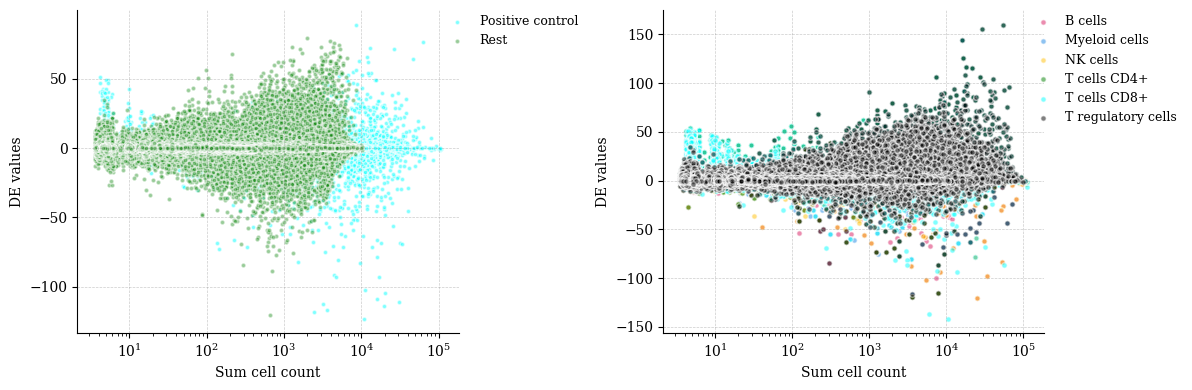

In [ ]:
colors = [
    "#D81B60",  # Vivid pink
    "#1E88E5",  # Bright blue
    "#FFC107",  # Amber
    "green",  # Deep teal
    "cyan",  # Yellow
    "black",  # Deep purple
]
def plotMA(df_x, df_y, obs_index, x_label='', y_label='', log=True):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
    for i_index, index in enumerate(obs_index):
        i = i_index // 2
        j = i_index % 2
        ax = axes[j]
        index_vars = df_x.index.get_level_values(index)
        if index=='sm_name':
            mask = (index_vars.isin(controls2))
            
            xs = df_x.loc[mask,:].values.flatten()
            ys = df_y.loc[mask,:].values.flatten() 
            sparse_mask = np.random.choice([True, False], len(xs), p=[.1,.9])
            ax.scatter(xs[sparse_mask], ys[sparse_mask], label='Positive control', alpha=0.5, color='cyan', edgecolors='white', s=10)

            xs = df_x.loc[~mask,:].values.flatten()
            ys = df_y.loc[~mask,:].values.flatten() 
            sparse_mask = np.random.choice([True, False], len(xs), p=[1,0])
            ax.scatter(xs[sparse_mask], ys[sparse_mask], label='Rest', alpha=0.4, color='green', edgecolors='white', s=10)
        else:
            included_vars = index_vars.unique()
            for i, var in enumerate(included_vars):
                color=colors[i]
                label = var
                mask = (index_vars == var)
                xs = df_x.loc[~mask,:].values.flatten()
                ys = df_y.loc[~mask,:].values.flatten()
                mask_top_quantile = ys > np.quantile(np.abs(ys), .95)
                np.random.seed(32)
                sparse_mask = np.random.choice([True, False], len(xs), p=[.05,.95])
                sparse_mask = sparse_mask | mask_top_quantile
                plt.scatter(xs[sparse_mask], ys[sparse_mask], label=var, alpha=.5, edgecolors='white', color=color, s=15)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if log:
            ax.set_xscale('log')
        ax.spines[['right', 'top']].set_visible(False)
        ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
        prop = {'size': 9}
        ax.legend(prop=prop, bbox_to_anchor=(.95, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.tight_layout()
plotMA(sum_count_genes, de_train, ['sm_name', 'cell_type'], x_label='Sum cell count', y_label='DE values', log=True)

## <a id='toc8_1_'></a>[Normality of the distribution](#toc0_)

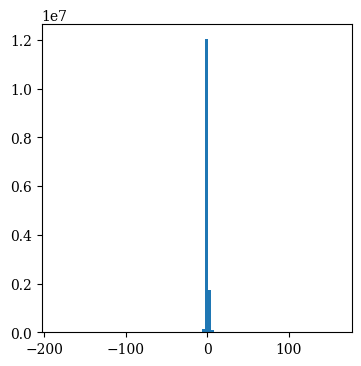

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=False)
data = de_train.values
aa = ax.hist(data.reshape(-1,1), bins=100)

## Variance 

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: xlabel='Cell count', ylabel='std'>,
        <Axes: xlabel='Cell count', ylabel='std'>], dtype=object))

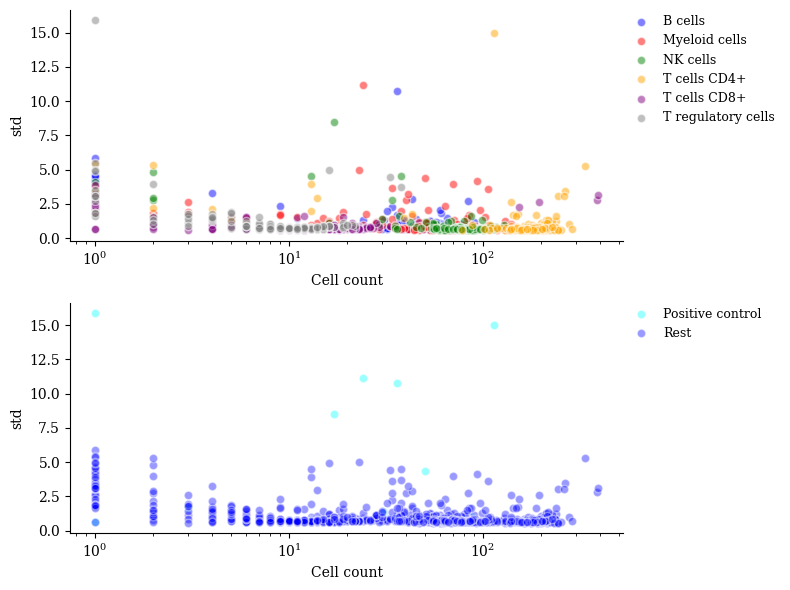

In [ ]:
xs = cell_count
ys = std

plot_scatter(de_train, obs_index, xs, ys, x_label='Cell count', y_label='std', log=True, figsize=(8, 6))

## Positive values

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: xlabel='Cell count', ylabel='Proportion of positive values'>,
        <Axes: xlabel='Cell count', ylabel='Proportion of positive values'>],
       dtype=object))

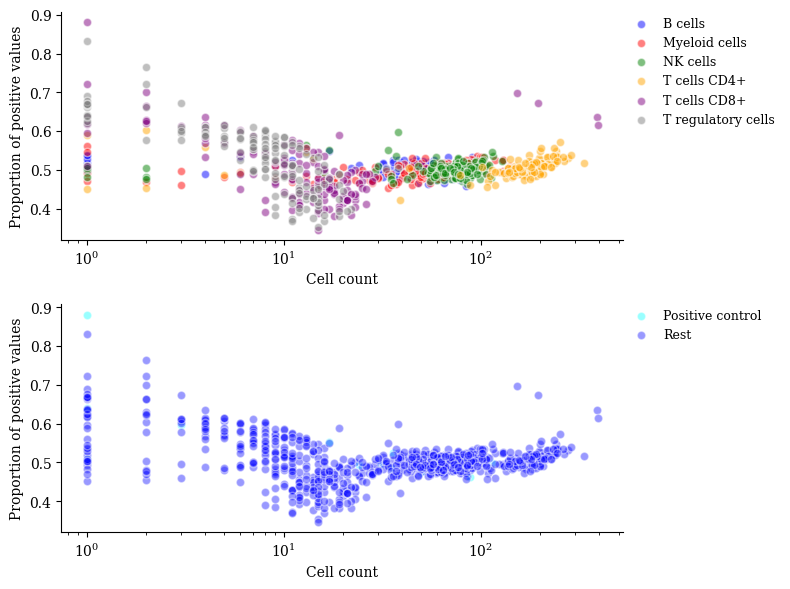

In [ ]:
xs = cell_count
ys = plus_values

plot_scatter(de_train, obs_index, xs, ys, x_label='Cell count', y_label='Proportion of positive values', log=True, figsize=(8, 6))

## Fraction of sig genes

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: xlabel='Cell count', ylabel='Fraction of sig genes'>,
        <Axes: xlabel='Cell count', ylabel='Fraction of sig genes'>],
       dtype=object))

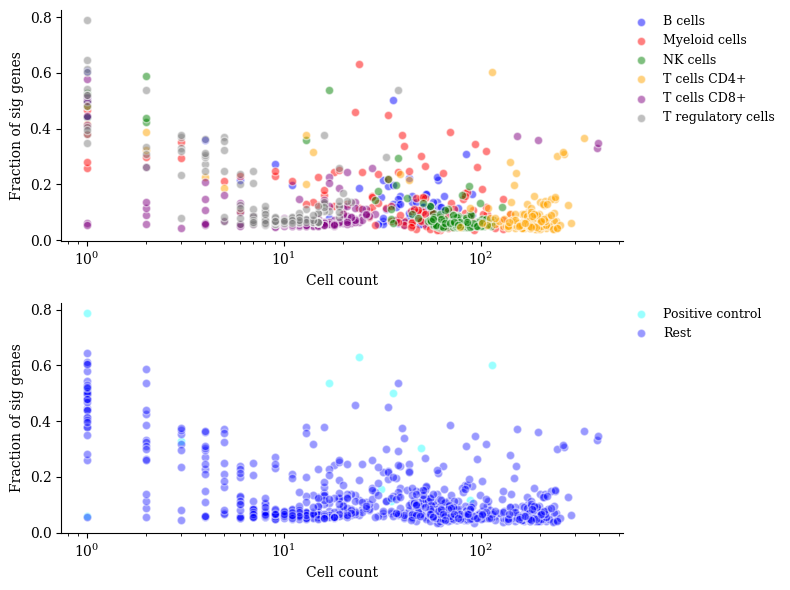

In [ ]:
sig_ratio = np.sum(de_train_p < 0.05, axis=1)/de_train_p.shape[1]

xs = cell_count
ys = sig_ratio

plot_scatter(de_train, obs_index, xs, ys, x_label='Cell count', y_label='Fraction of sig genes', log=True, figsize=(8, 6))

## Low dimentional representation

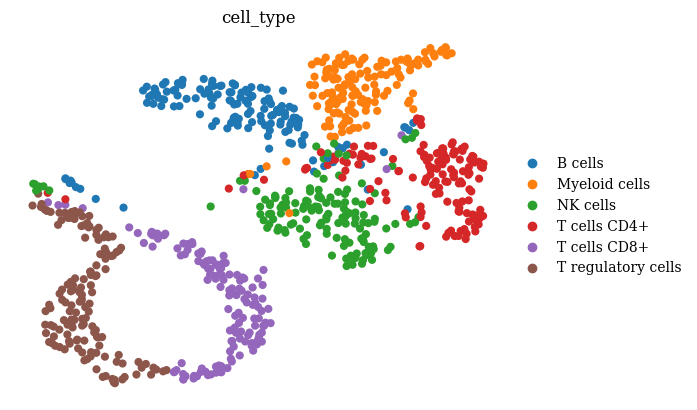

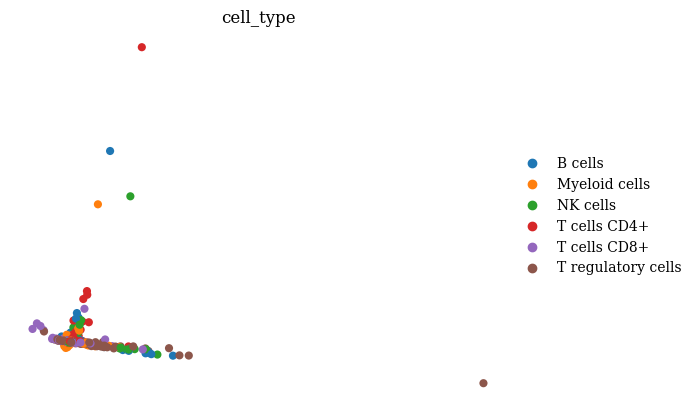

In [ ]:
df = de_train
obs=df.index.to_frame().reset_index(drop=True)
var=pd.DataFrame(index=df.columns)
adata = ad.AnnData(X=df.values, obs=obs , var=var)
with warnings.catch_warnings():
    # custom_normalize(adata)
    # sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata)
    sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['cell_type'], frameon=False)
    sc.pl.pca(adata, color=['cell_type'], frameon=False)

## Housekeeping genes

In [ ]:
housekeeping_genes = np.loadtxt(f'{work_dir}/benchmark/housekeeping_genes.txt', dtype=str)
mask_hkgs = de_train.columns.isin(housekeeping_genes)
bulk_adata_f = ad.read_h5ad(f'{work_dir}/preprocess/bulk_adata_f.h5ad')
adata_ = bulk_adata_f[:, bulk_adata_f.var.index.isin(de_train.columns)]
adata_df = pd.DataFrame(adata_.X, index= pd.MultiIndex.from_frame(adata_.obs[bulk_index]), columns=adata_.var.index )
sum_count_genes = adata_df.groupby(['sm_name', 'cell_type']).sum().reindex_like(de_train)
sig_mask = de_train_p<0.05

In [ ]:
sig_sum_genes = np.sum(de_train_p < 0.05, axis=0)
# sig_sum_genes[mask_hkgs].sum()/mask_hkgs.sum()
sig_sum_genes[~mask_hkgs].sum()/(~mask_hkgs).sum()

105.9849828820417

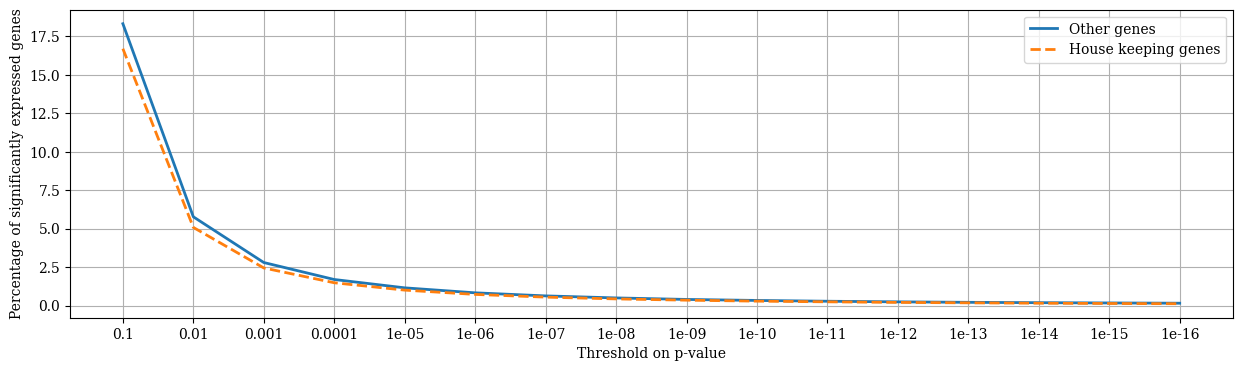

In [ ]:
import matplotlib.pyplot as plt


d = pd.DataFrame(); IX = -1
list_thresholds = [0.1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16]

data_df = de_train

for t in list_thresholds:
    # remaining all genes
    v  = data_df.loc[:, ~mask_hkgs].values.ravel()
    v = v[~np.isnan(v)]
    v = 10**(-np.abs(v))
    m = v < t
    IX+=1
    d.loc[IX, 'Threshold'] = t
    d.loc[IX, 'Other genes'] = 100*m.sum()/len(v)

    v  = data_df.loc[:, mask_hkgs].values.ravel()
    v = v[~np.isnan(v)]
    v = 10**(-np.abs(v))
    m = v < t
    d.loc[IX, 'House keeping genes'] = 100*m.sum()/len(v)

# Define line styles and line width
line_styles = ['-', '--', '-.', ':']
line_width = 2  # Increase the line thickness

plt.figure(figsize=(15, 4))

# Iterate over columns and line styles
for col, style in zip(d.columns[1:], line_styles * (len(d.columns) // len(line_styles) + 1)):
    plt.plot(d[col].values, label=col, linestyle=style, linewidth=line_width)

plt.grid()
plt.legend()
plt.xticks(range(len(list_thresholds)), list_thresholds)
plt.xlabel('Threshold on p-value')
plt.ylabel('Percentage of significantly expressed genes')
plt.savefig('sig.png', bbox_inches='tight')

plt.show()

In [ ]:
abs_diff = []
for t in list_thresholds:
    sig_sum = (de_train_p<t).sum(axis=0)
    hkgs_sum  = sig_sum[mask_hkgs].sum()/mask_hkgs.sum()
    rest_sum = sig_sum[~mask_hkgs].sum()/(~mask_hkgs).sum()


    abs_diff.append(rest_sum - hkgs_sum)
abs_diff

[14.102128283652803,
 5.989887461726148,
 3.072918381012478,
 1.8427169214305152,
 1.2895761296350052,
 0.8930893979479402,
 0.6964390125698934,
 0.5586127768694329,
 0.4150946374022495,
 0.39536032895591067,
 0.33215482827320475,
 0.31210680315822836,
 0.28857894894991754,
 0.3016587010751548,
 0.30505086593243735,
 0.29014312151393384]

In [ ]:
std_for_genes.shape

(16239,)

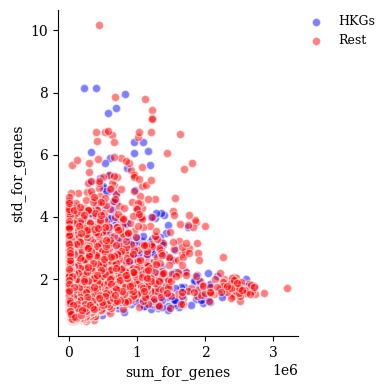

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(4,4), sharey=False)

colors = ['blue', 'red', 'green', 'orange', 'purple', 'gray']

ax.scatter(sum_for_genes[mask_hkgs], std_for_genes[mask_hkgs], label='HKGs', alpha=0.5, edgecolors='white', color=colors[0])
ax.scatter(sum_for_genes[~mask_hkgs], std_for_genes[~mask_hkgs], label='Rest', alpha=0.5, edgecolors='white', color=colors[1])
    
ax.set_xlabel('sum_for_genes')
ax.set_ylabel('std_for_genes')

ax.margins(0.05)
ax.spines[['right', 'top']].set_visible(False)
# ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
prop = {'size': 9}
ax.legend(prop=prop, bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, frameon=False)
#plt.axvline(x=25, linestyle='--', linewidth=1, color='black')
plt.tight_layout()


collection: original

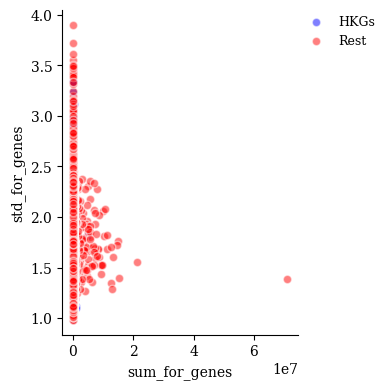